In [1]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import pickle
from sklearn.linear_model import LinearRegression


# Auto_sklearn Models

In [2]:
res = pd.read_csv("correct_choices.csv")
res

dataset    lr_acc  lr_auroc  knn_pca_acc  knn_pca_auroc  rf_pca_acc  \
0  birth_randoms  0.777966  0.833898     0.831073       0.871186    0.724294   
1   ring_randoms  0.842373  0.836723     0.700000       0.669492    0.546328   
2  adult_randoms  0.779661  0.885876     0.663842       0.722599    0.718644   
3  heart_randoms  0.942938  0.904520     0.774011       0.879096    0.644633   

   rf_pca_auroc  
0      0.858757  
1      0.614124  
2      0.837288  
3      0.648023

In [3]:
birth = pd.read_csv("birth_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)
ring = pd.read_csv("ring_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)
adult = pd.read_csv("adult_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)
heart = pd.read_csv("heart_randoms/metrics.csv").drop(["lr_acc", "auroc"], axis=1)

birth_accs = pd.read_csv("birth_randoms/accuracy_results.csv")
ring_accs = pd.read_csv("ring_randoms/accuracy_results.csv")
adult_accs = pd.read_csv("adult_randoms/accuracy_results.csv")
heart_accs = pd.read_csv("heart_randoms/accuracy_results.csv")

metrics = pd.concat([birth, ring, adult, heart], keys=["birth", "ring", "adult", "heart"], 
                    names=["dataset"], sort=False).reset_index().drop("level_1", axis=1)
accs = pd.concat([birth_accs, ring_accs, adult_accs, heart_accs], keys=["birth", "ring", "adult", "heart"], 
                 names=["dataset"], sort=False)
accs = accs.drop(["knn_acc", "knn_auroc", "rf_acc", "rf_auroc", "lr_pca_acc", "lr_pca_auroc"], 
                 axis=1).reset_index().drop("level_1", axis=1)
accs

dataset              algo   no  knn_pca_auroc  knn_pca_acc  rf_pca_auroc  \
0      birth           datafly    1       0.464272     0.406780      0.568481   
1      birth  datafly_shuffled    1       0.589675     0.440678      0.613460   
2      birth          mondrian    1       0.621924     0.450847      0.643375   
3      birth           datafly    2       0.441660     0.335593      0.596937   
4      birth  datafly_shuffled    2       0.464272     0.406780      0.578368   
...      ...               ...  ...            ...          ...           ...   
2395   heart  datafly_shuffled  199       0.579031     0.856557      0.668391   
2396   heart          mondrian  199       0.613002     0.844262      0.676950   
2397   heart           datafly  200       0.648956     0.856557      0.653968   
2398   heart  datafly_shuffled  200       0.648956     0.856557      0.654409   
2399   heart          mondrian  200       0.560173     0.856557      0.671018   

      rf_pca_acc  lr_auroc    lr_acc  
0       0.437288  0.583774  0.430508  
1       0.437288  0.619309  0.477966  
2       0.474576  0.627022  0.461017  
3       0.437288  0.603186  0.433898  
4       0.437288  0.583774  0.430508  
...          ...       ...       ...  
2395    0.856557  0.675628  0.855191  
2396    0.856557  0.508012  0.730874  
2397    0.856557  0.653285  0.857923  
2398    0.856557  0.653285  0.857923  
2399    0.856557  0.575013  0.711749  

[2400 rows x 9 columns]

# 1) Metric plots
Ici, les plots des metrics vs. les differentes mesures d'utilité. Chaque dataset a un marker different, et une regression lineaire dessus de la couleur correspondante

In [4]:
plot_info = [(birth, birth_accs, "b", "x", "birth"),
            (ring, ring_accs, "r", "o", "ring"),
            (adult, adult_accs, "g", "+", "adult"),
            (heart, heart_accs, "y", "*", "heart")]

def plot_metric(metric, target_var):    
    plt.figure(figsize=(12,8))
    
    for dataset, acc_set, col, mark, label in plot_info:
        plt.scatter(dataset[metric], acc_set[target_var], c=col, marker=mark, alpha=0.5, label=label)
        
        X = dataset[metric].values.reshape(-1,1)
        y = acc_set[target_var]
        
        lin_reg = LinearRegression().fit(X, y)
        #print(label, lin_reg.coef_, lin_reg.intercept_)
        x=[[0],[1]]
        plt.plot(x, lin_reg.predict(x), c=col)

        plt.title(f"{metric} vs. {target_var}")
        plt.xlabel(metric)
        plt.ylabel(target_var)
        plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

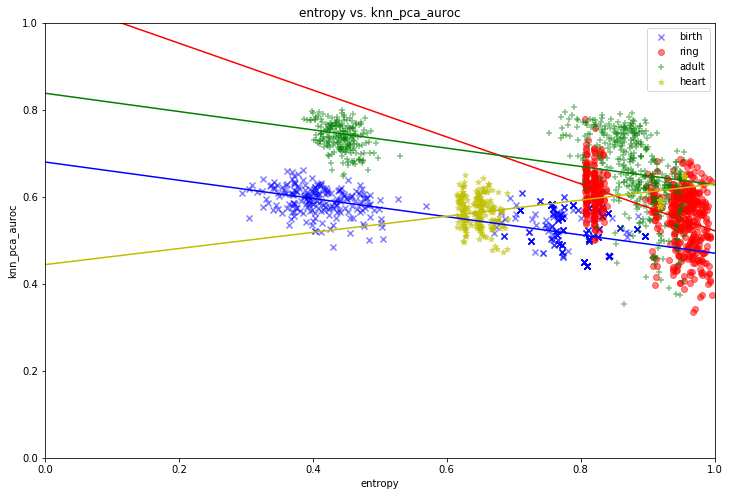

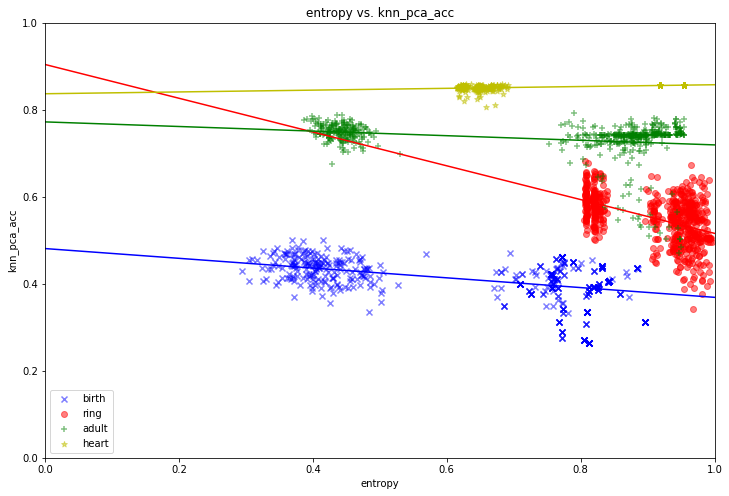

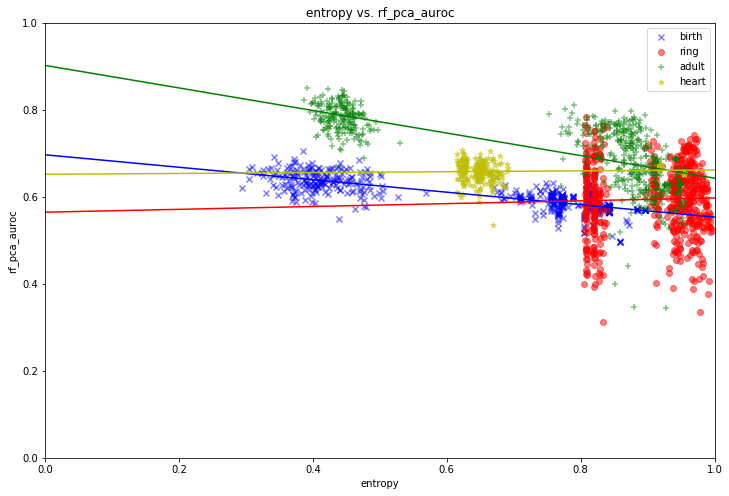

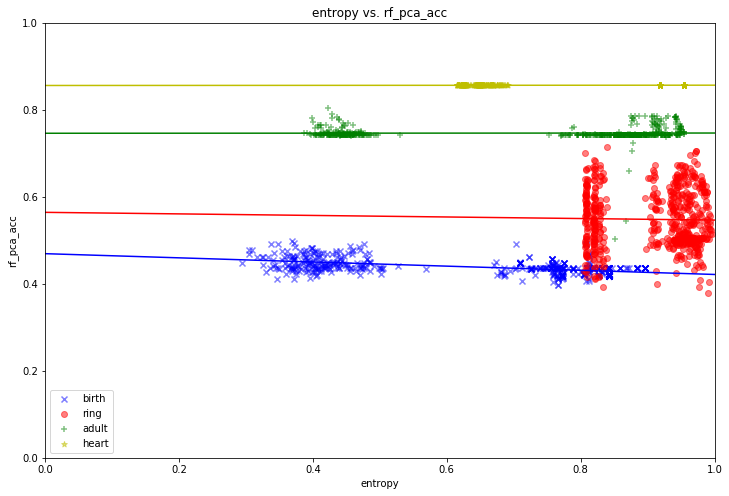

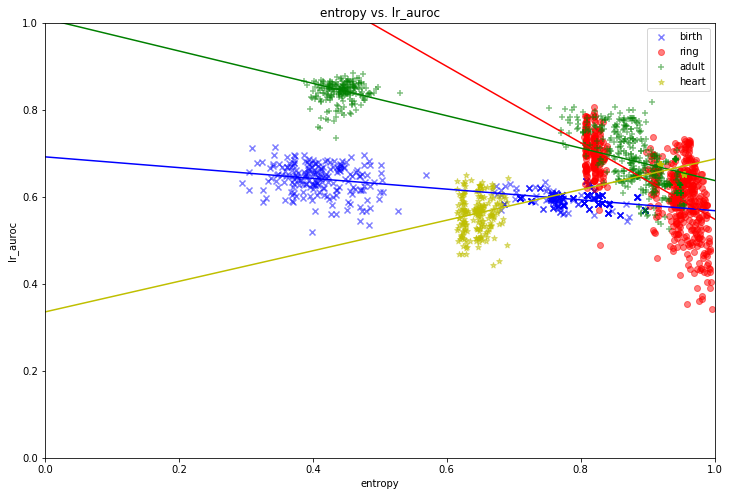

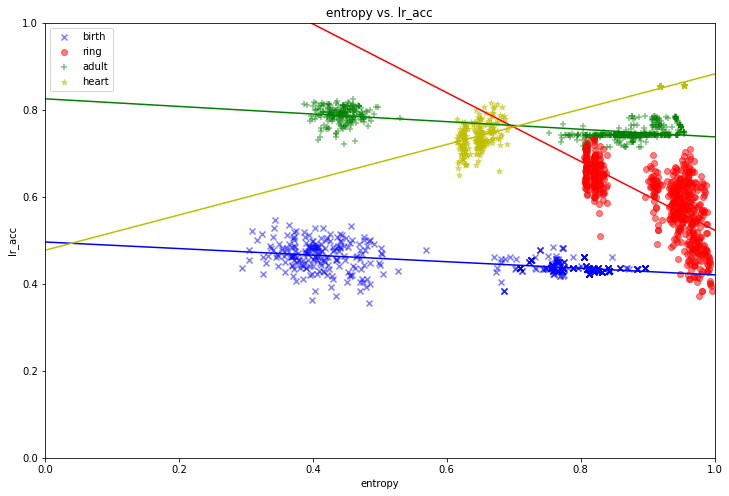

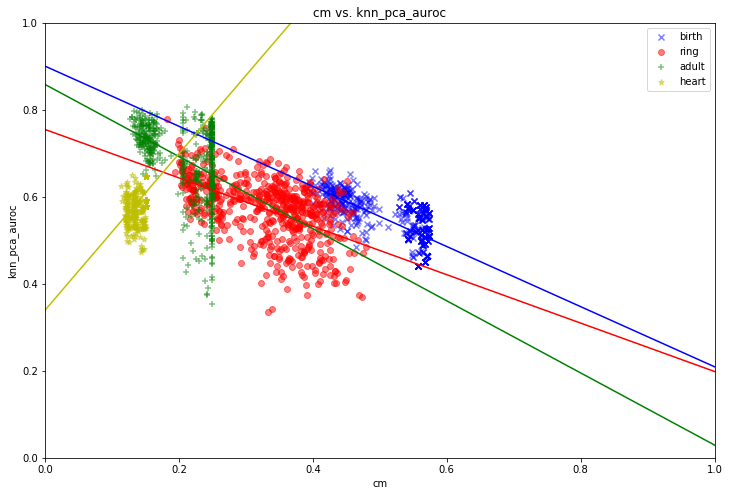

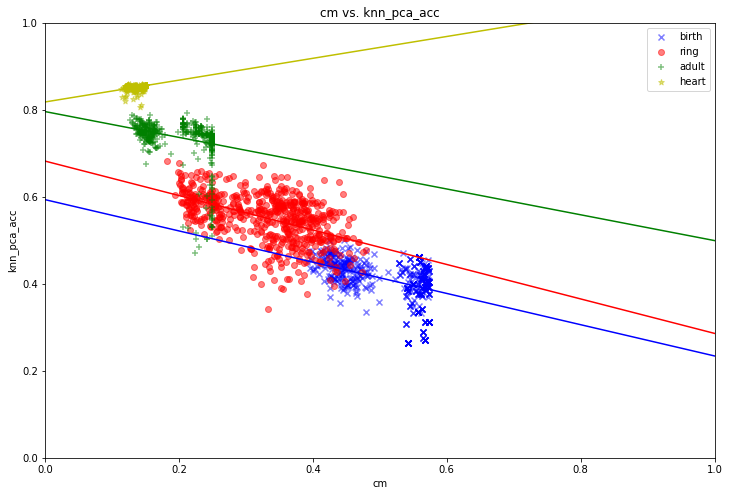

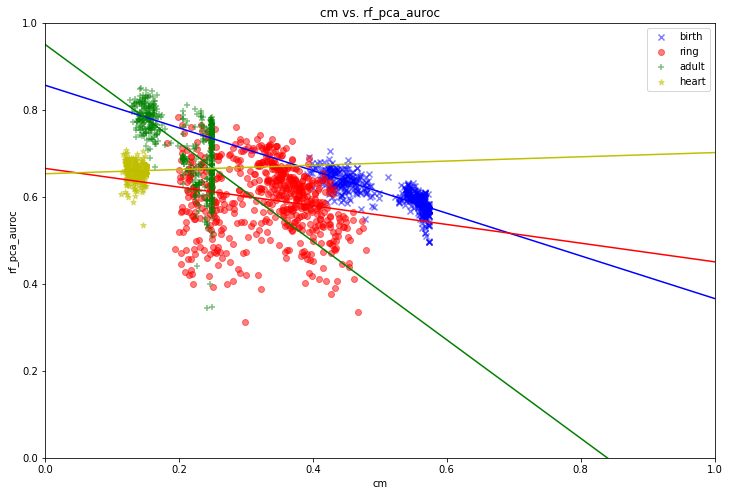

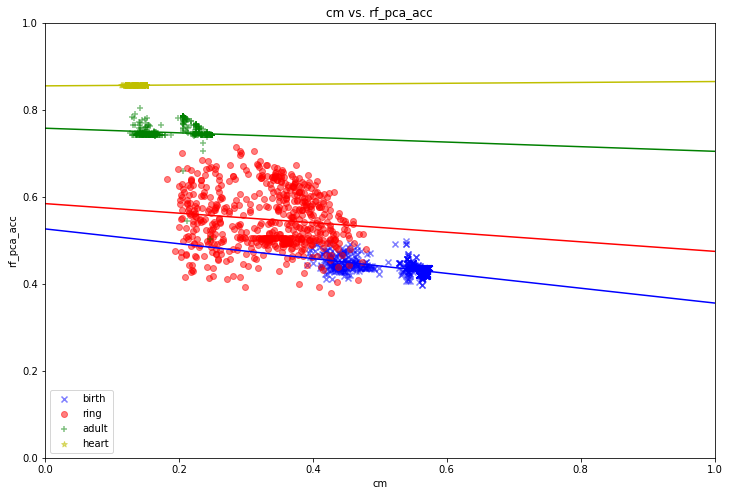

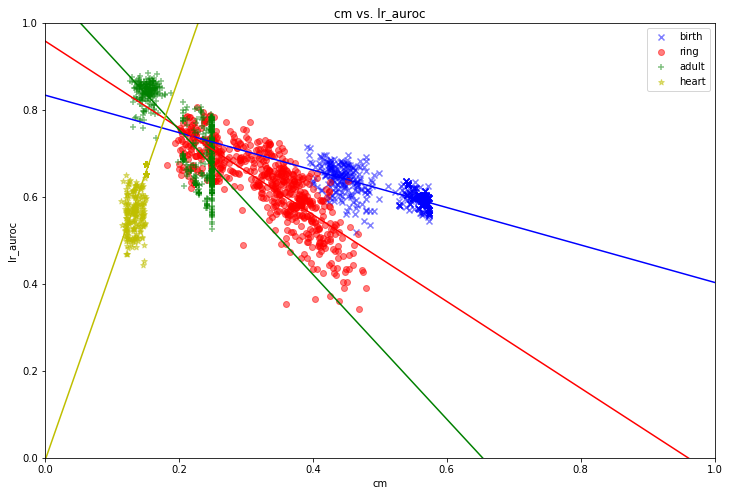

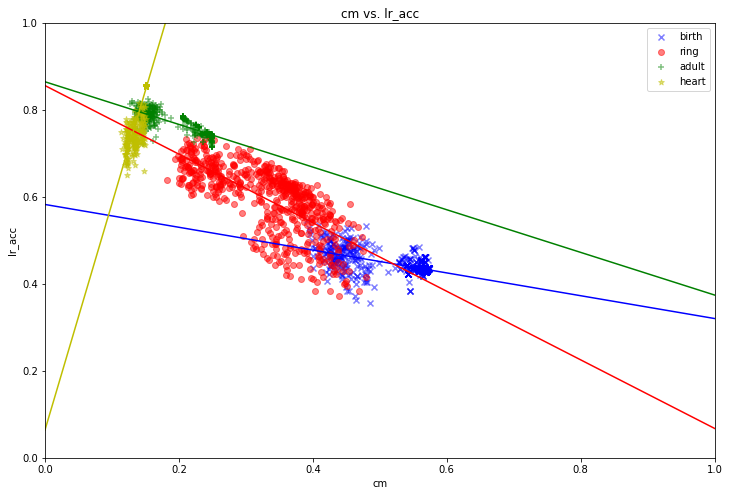

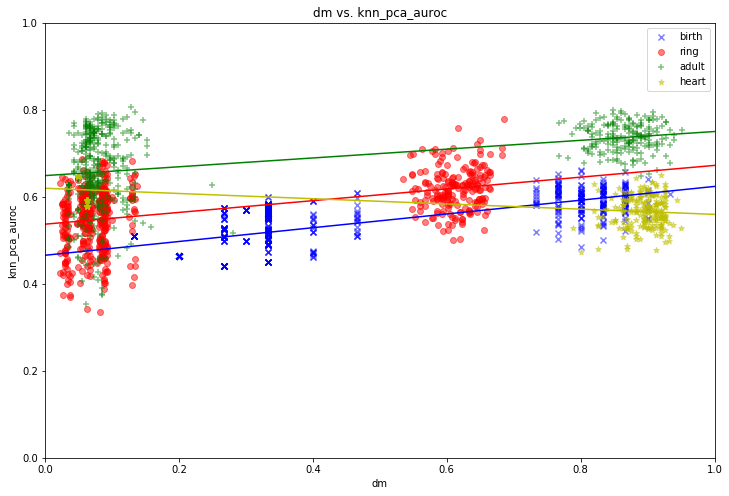

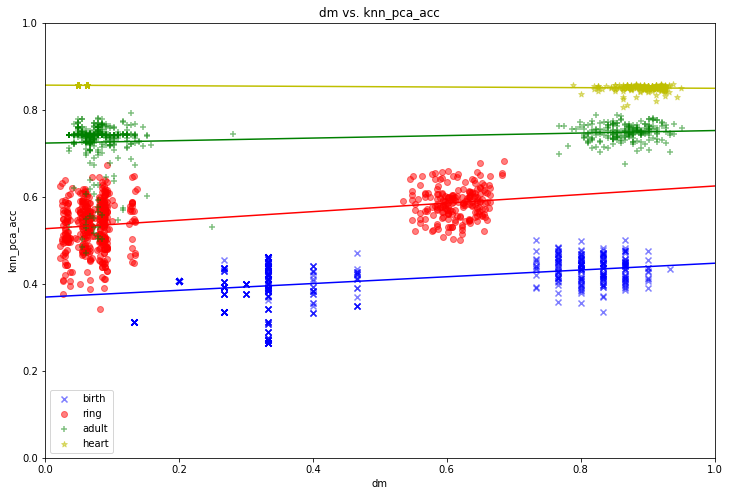

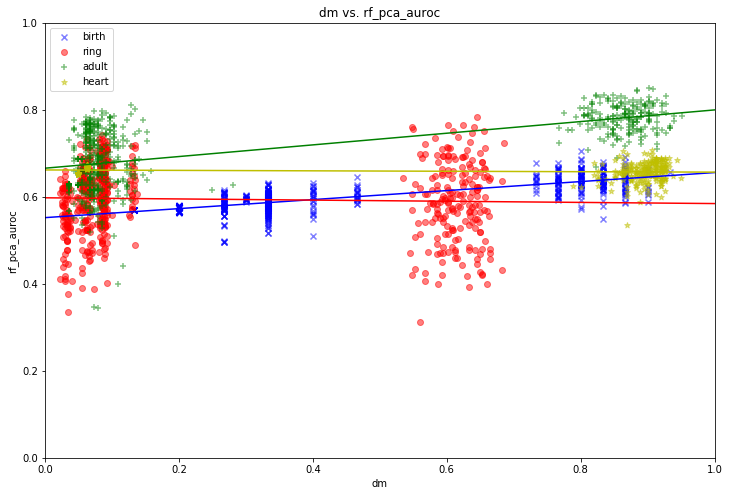

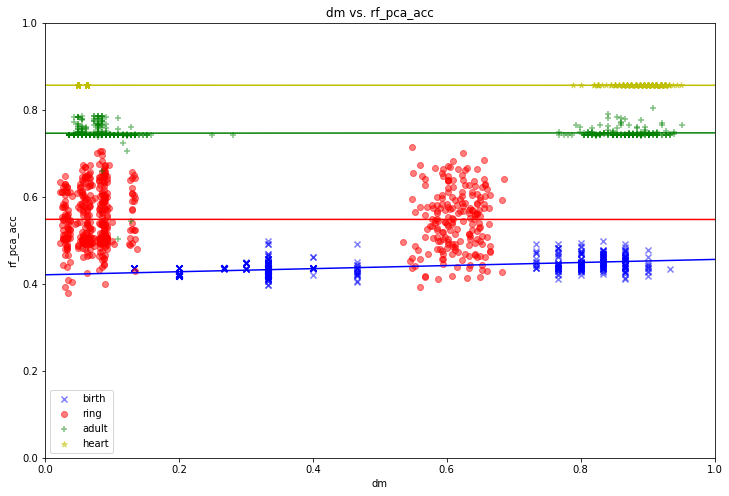

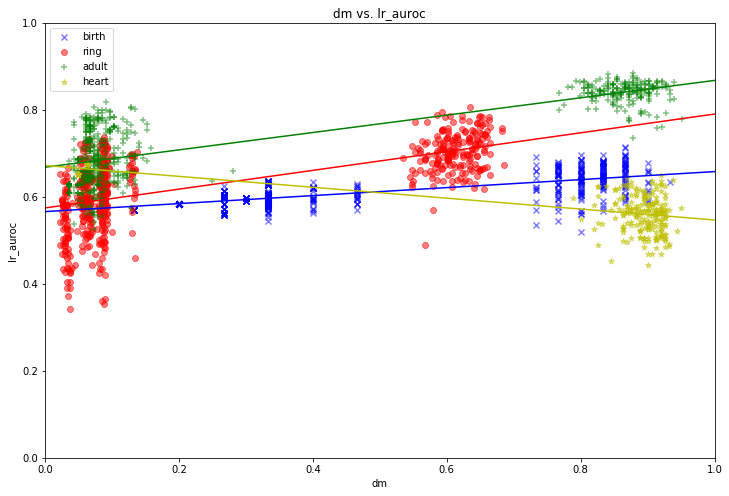

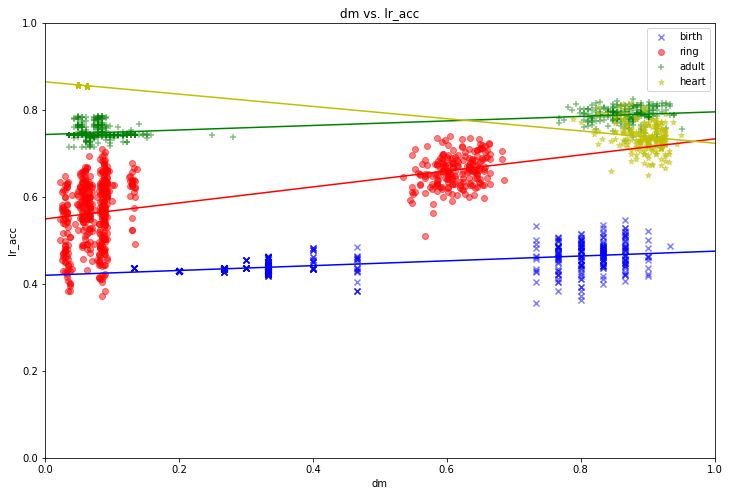

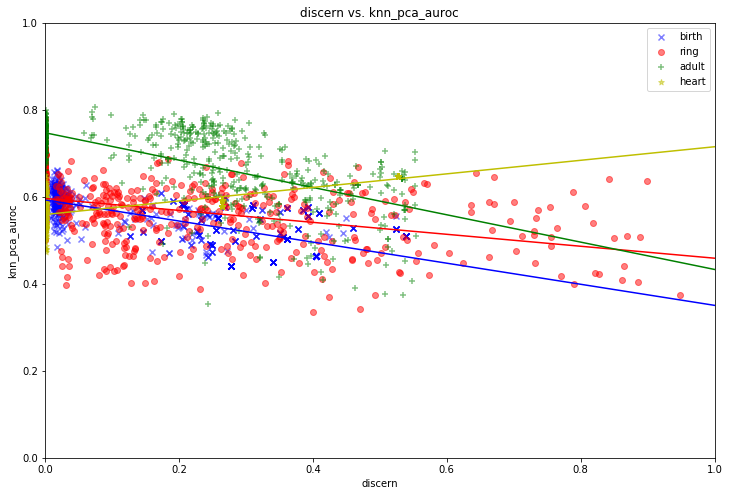

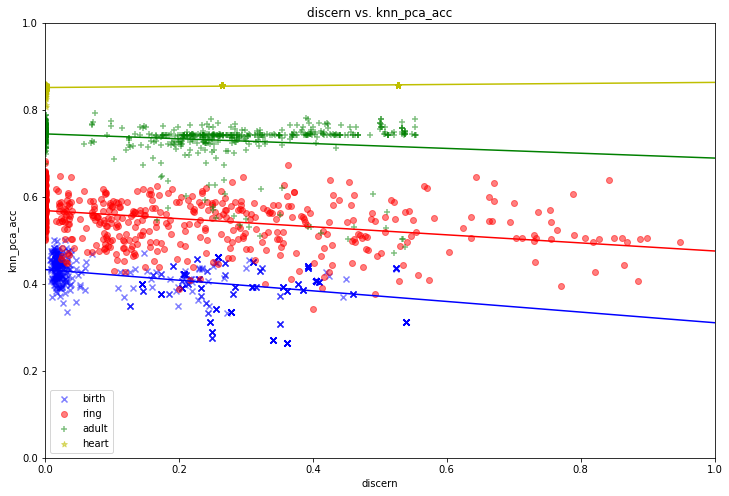

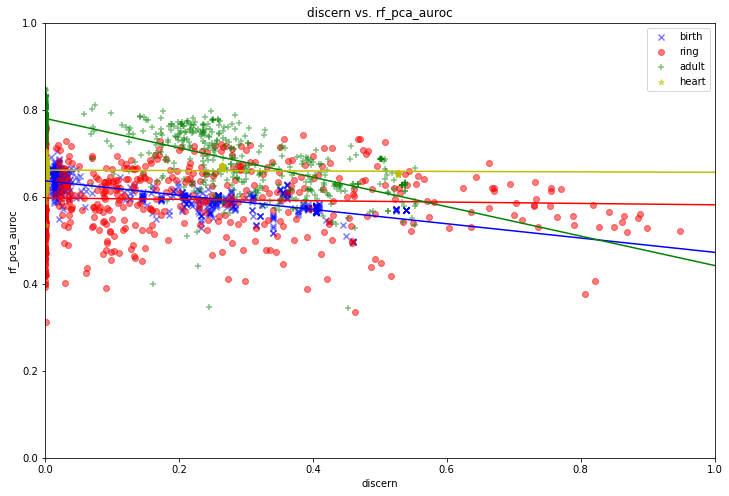

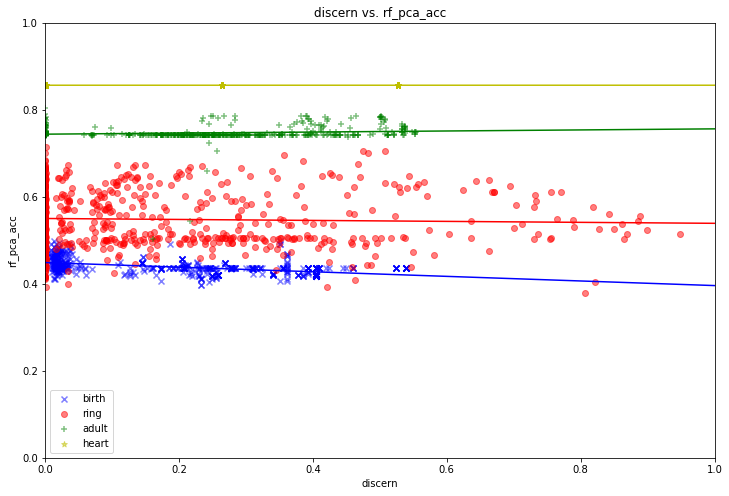

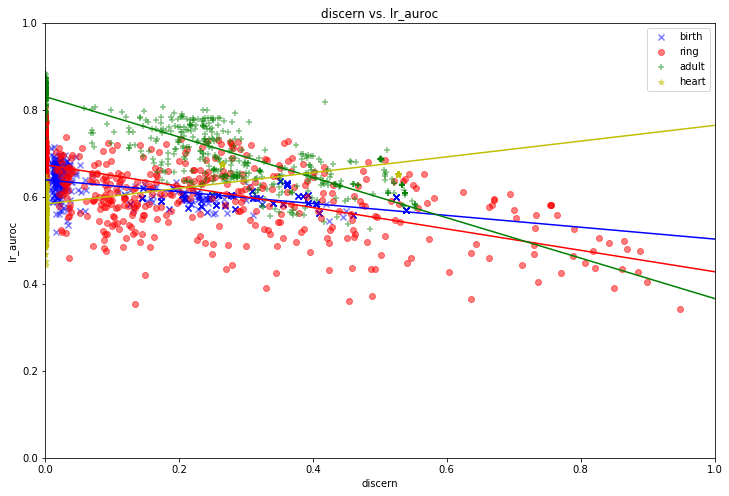

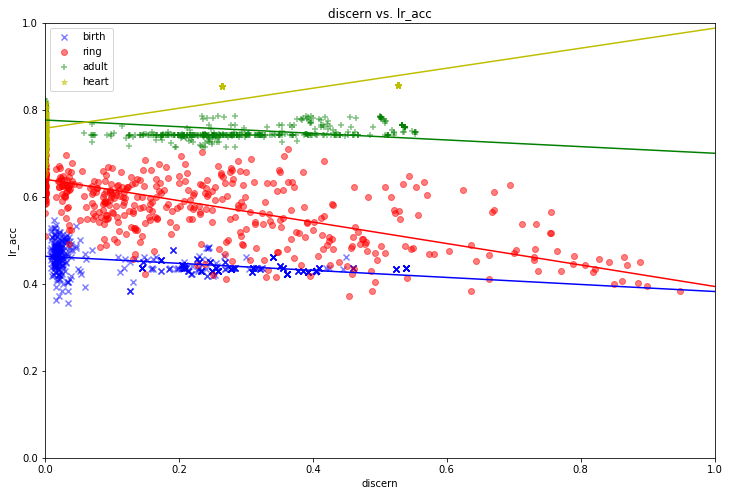

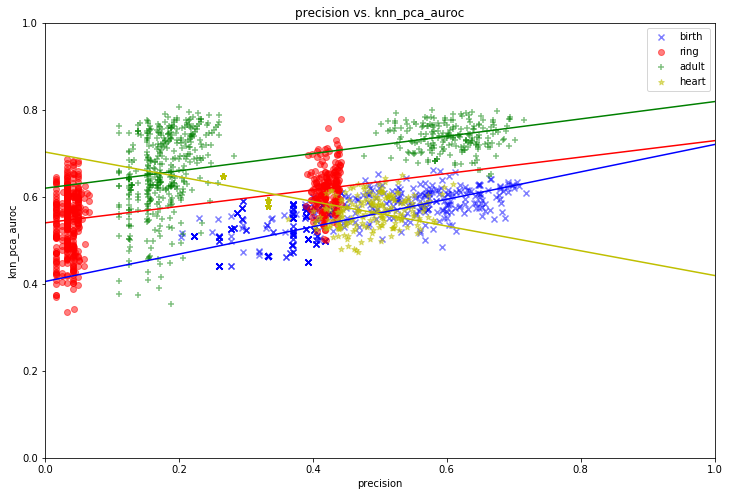

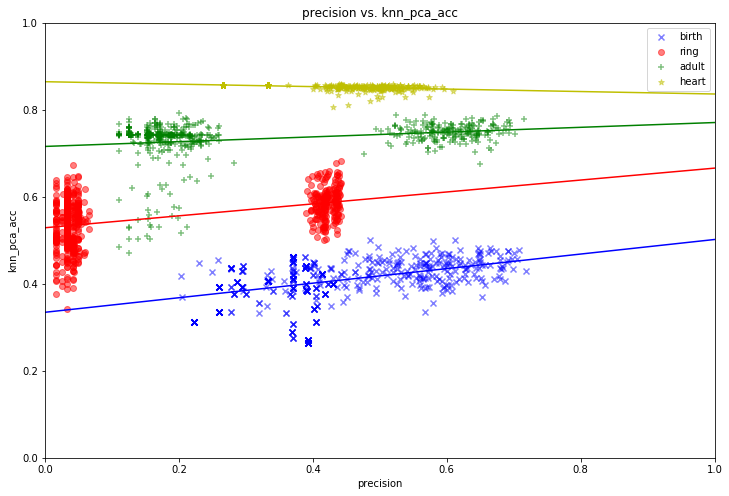

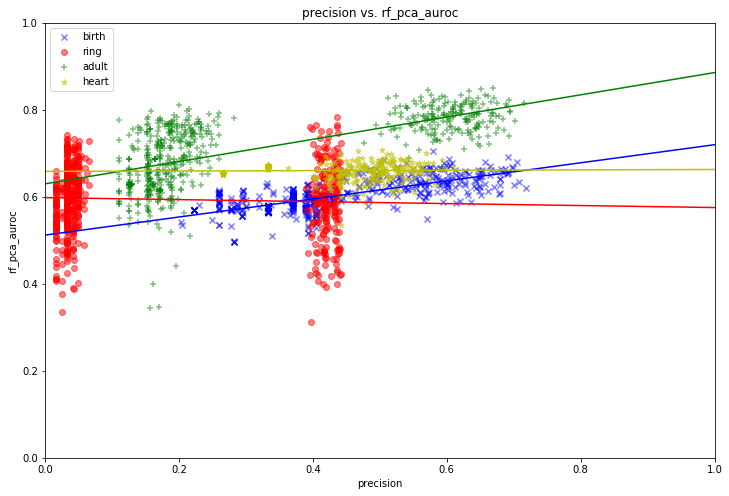

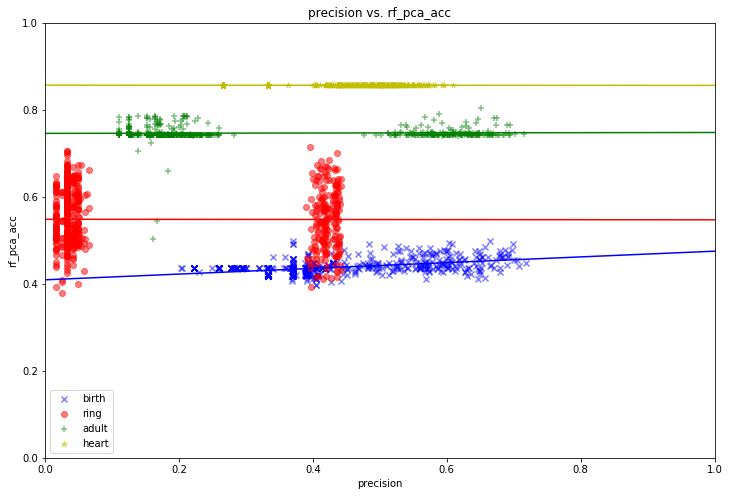

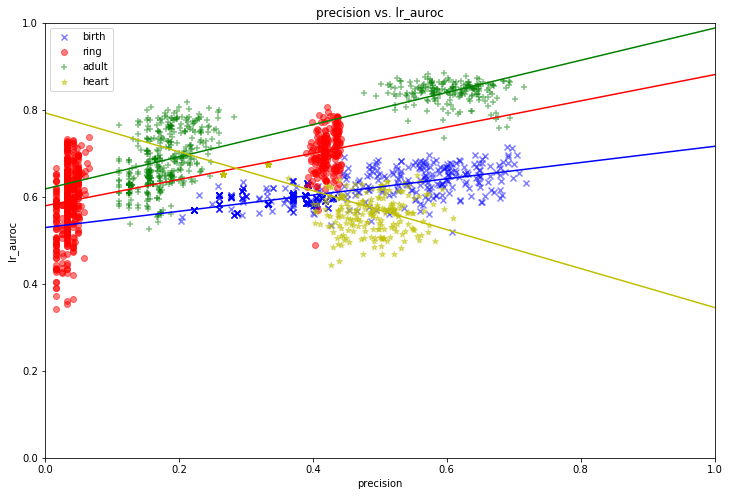

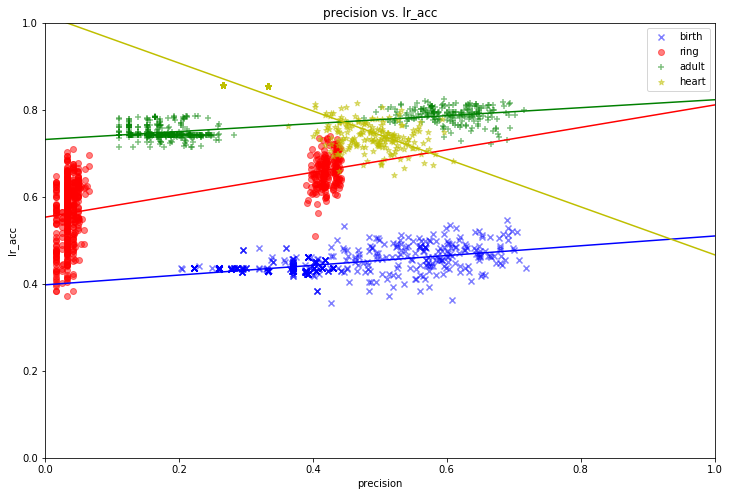

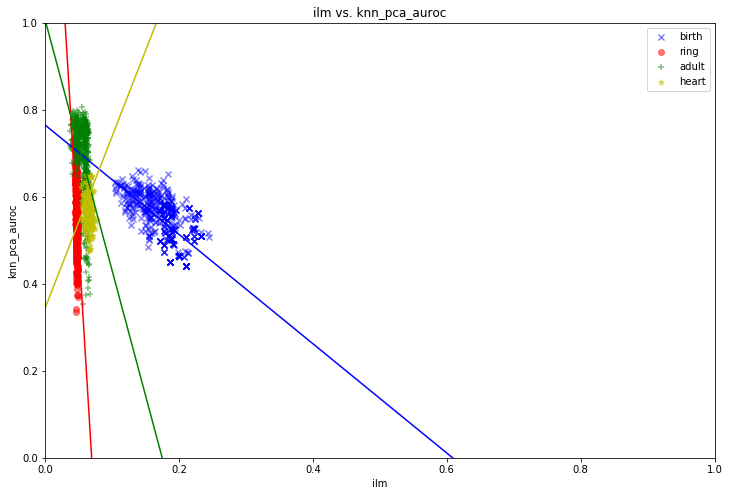

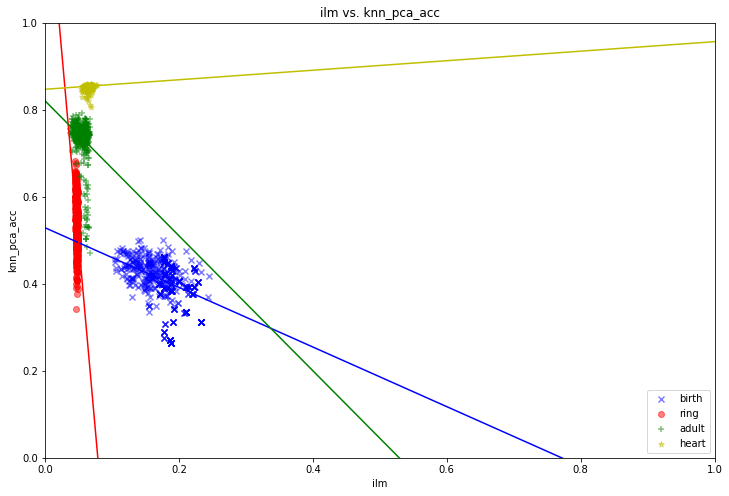

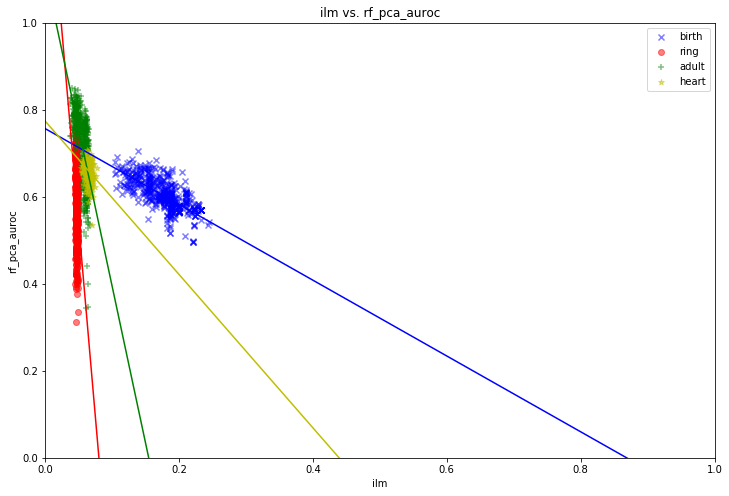

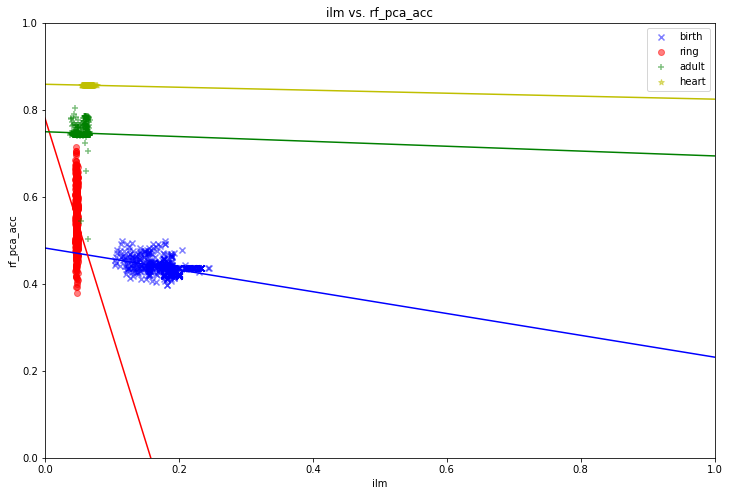

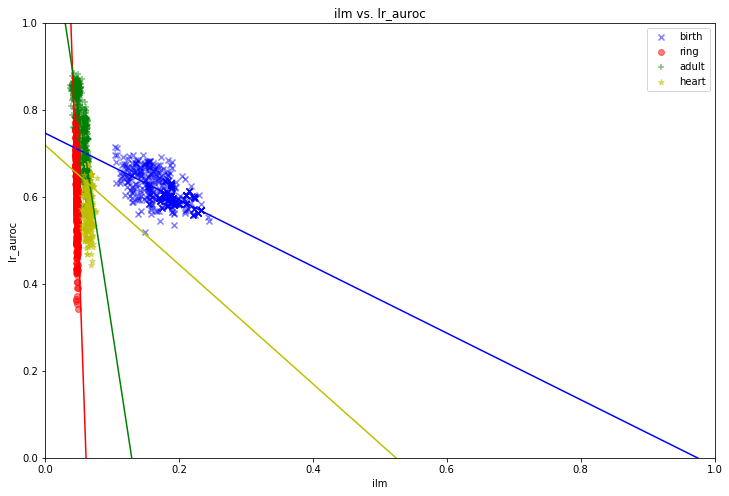

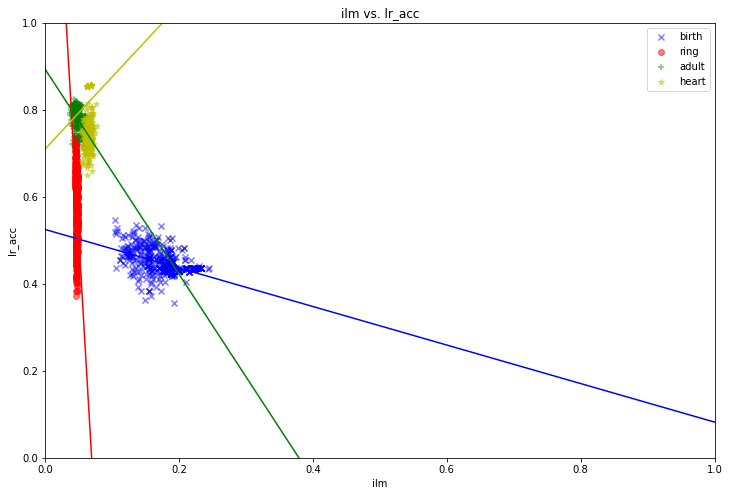

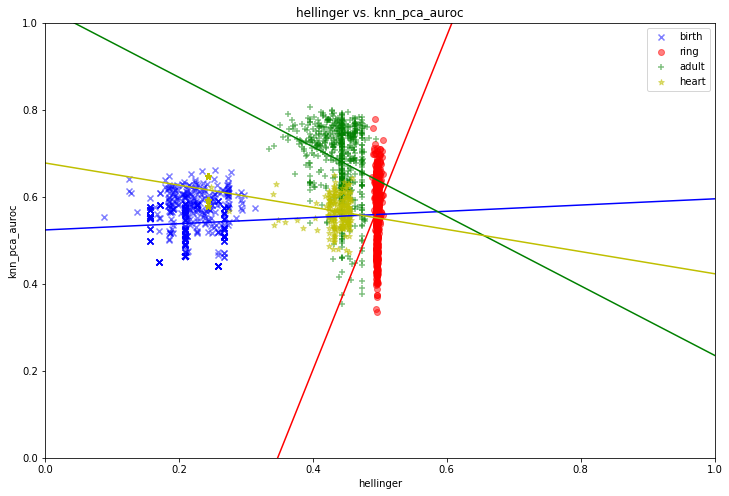

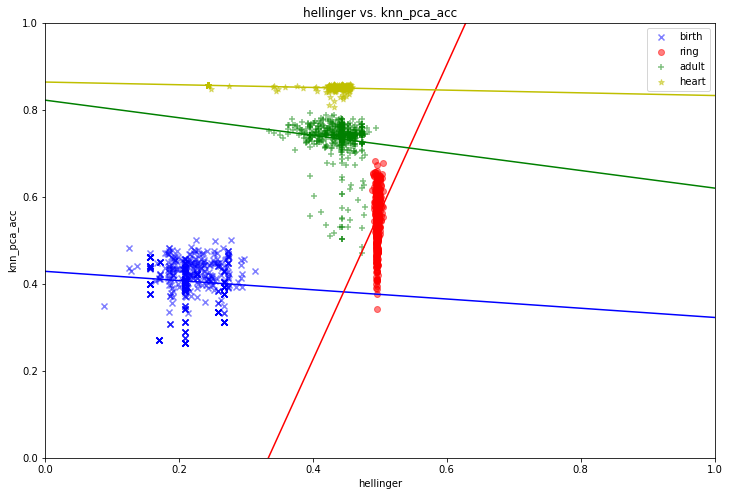

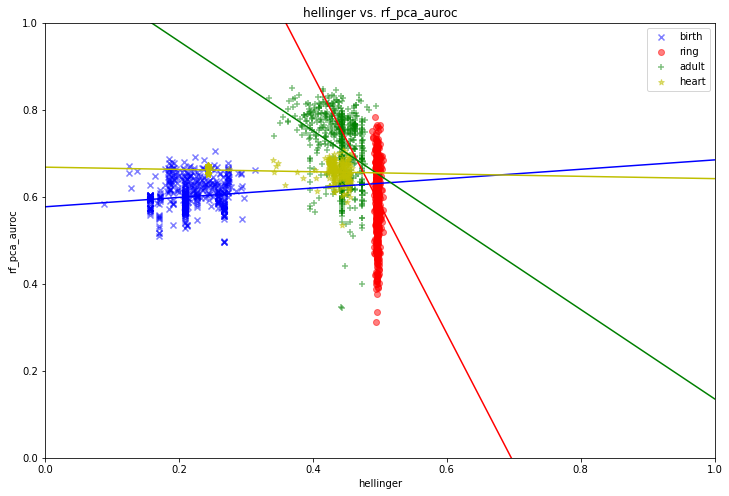

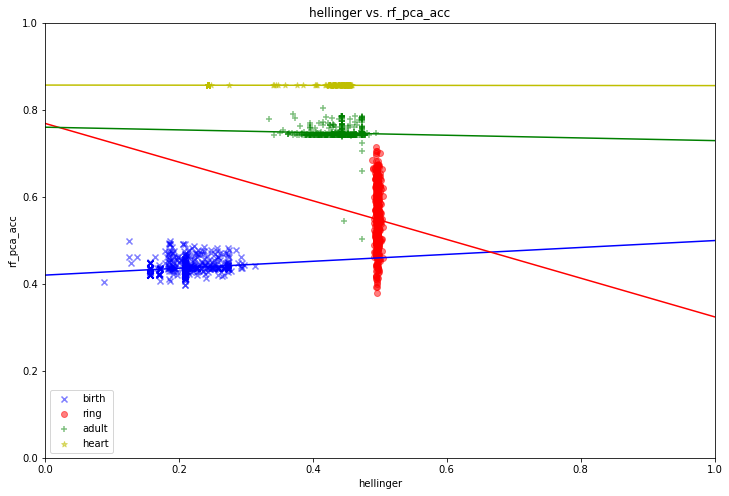

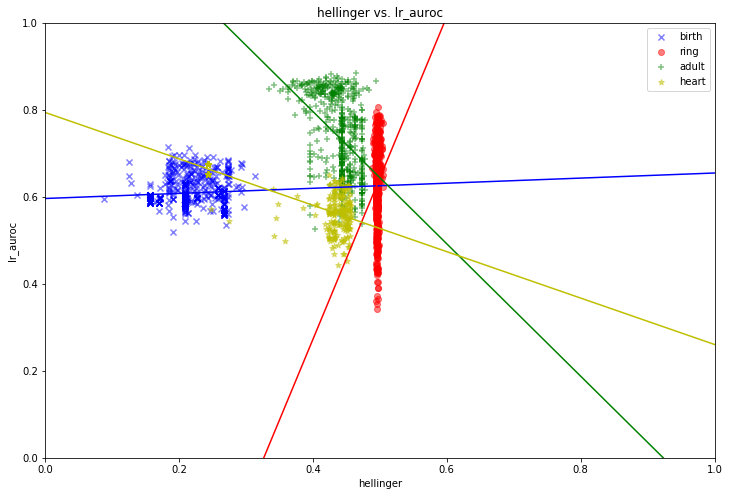

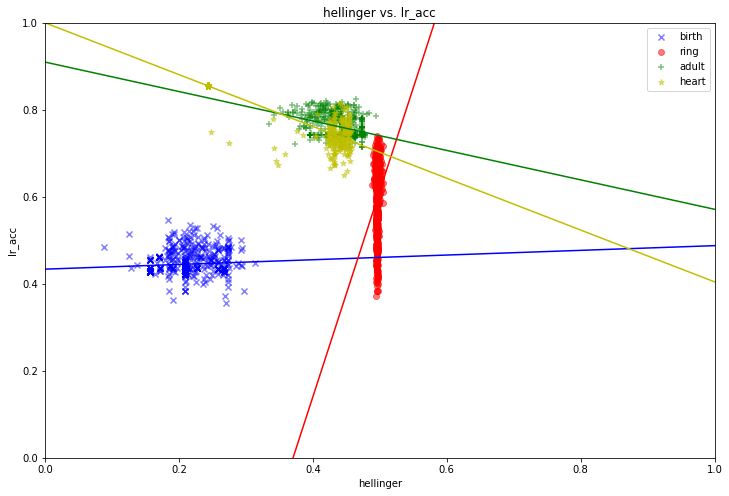

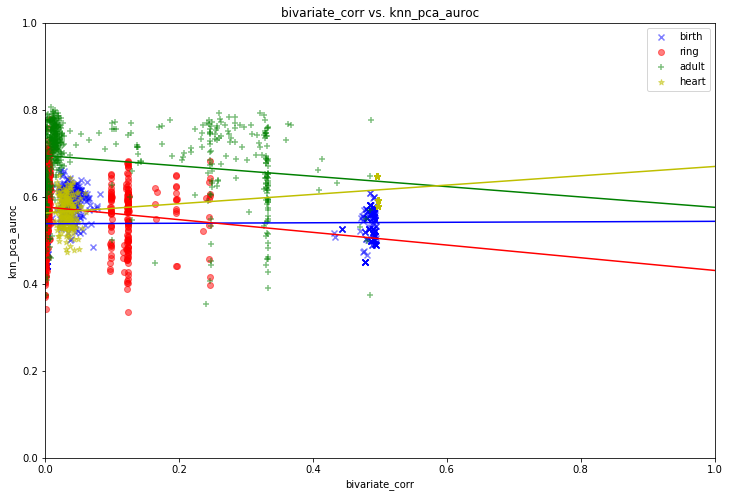

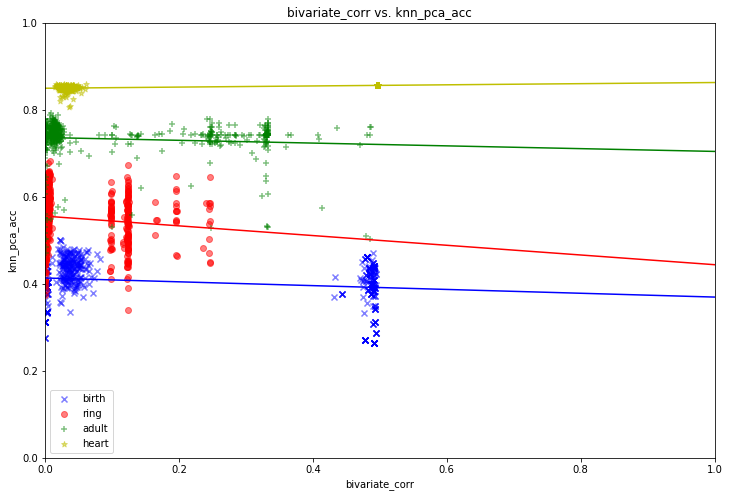

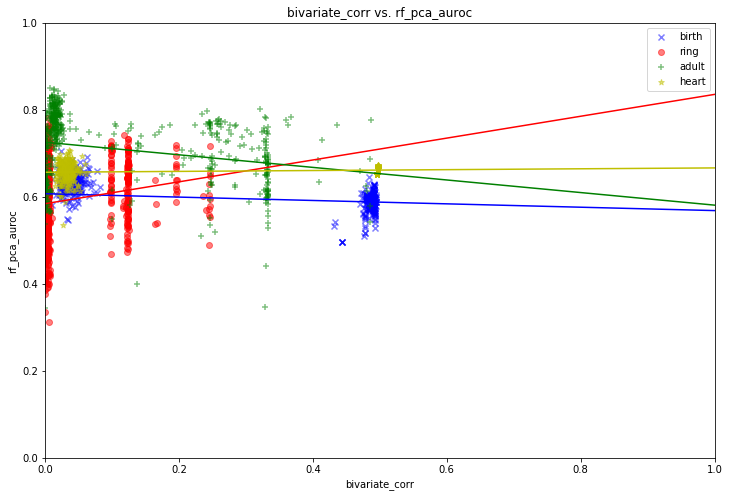

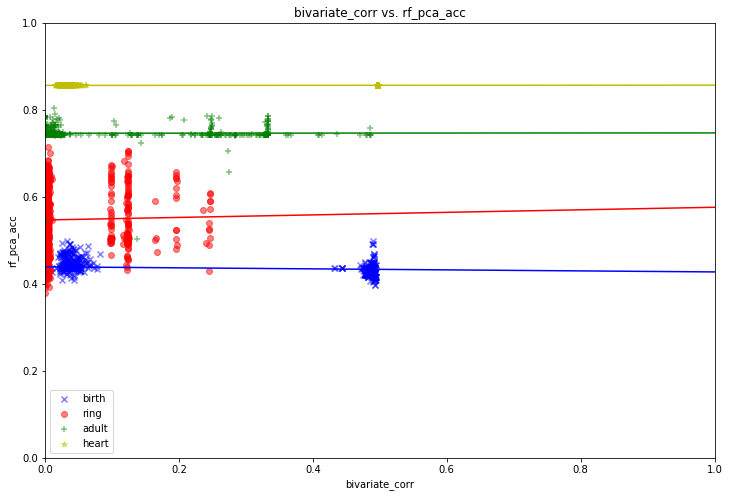

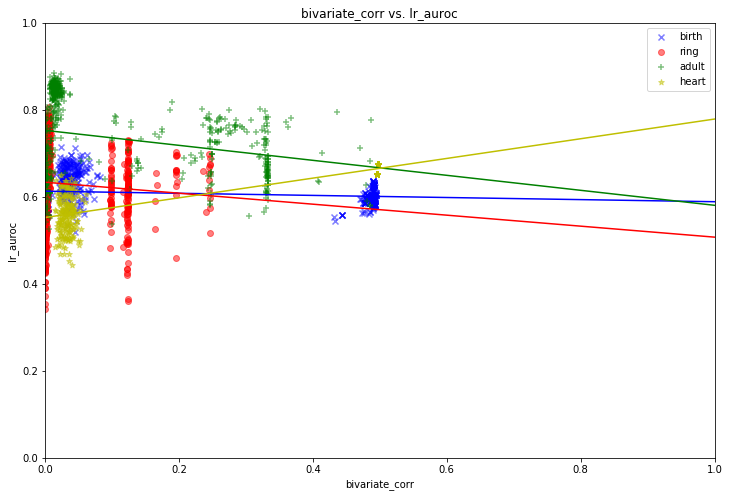

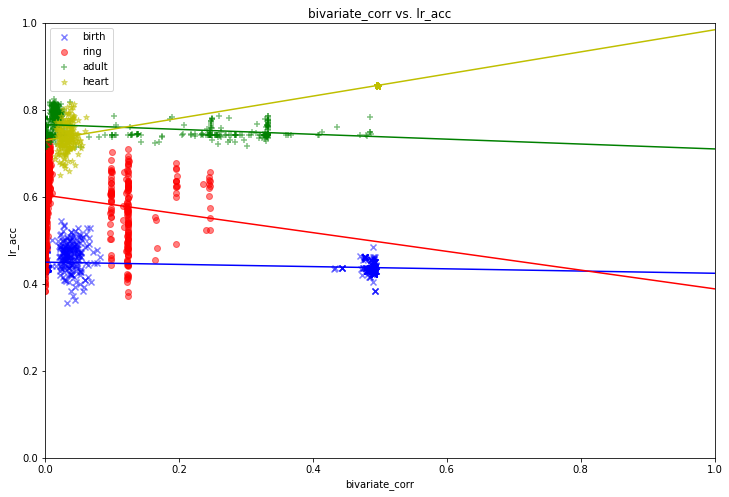

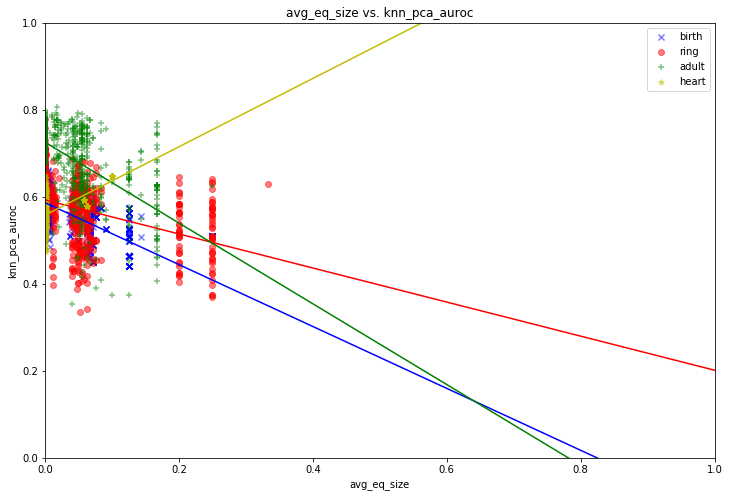

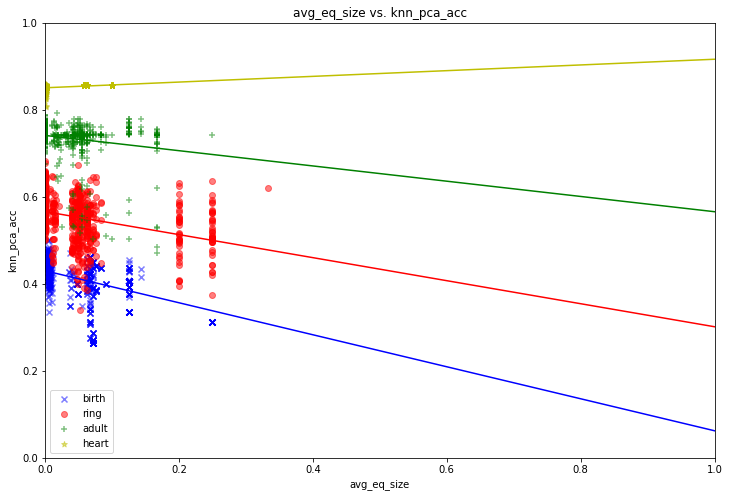

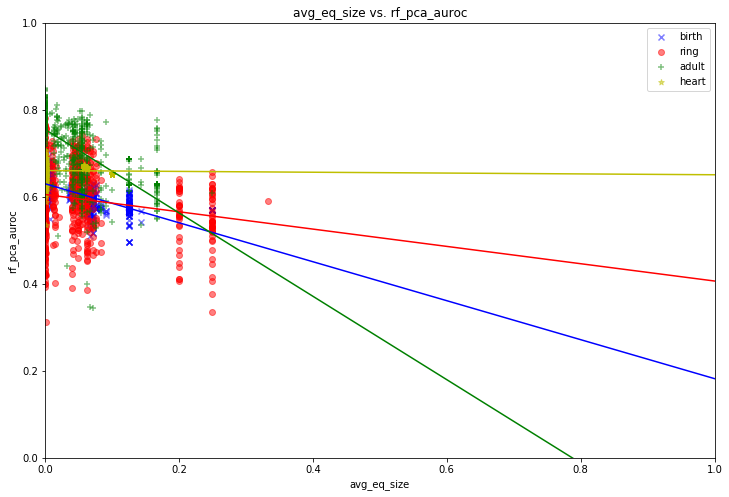

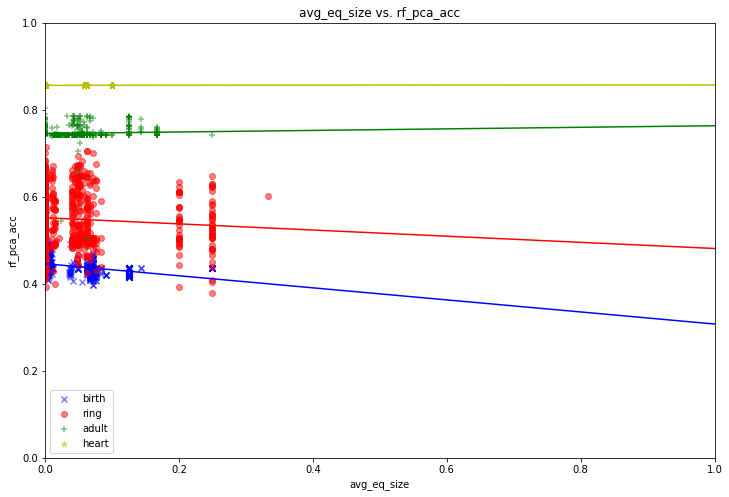

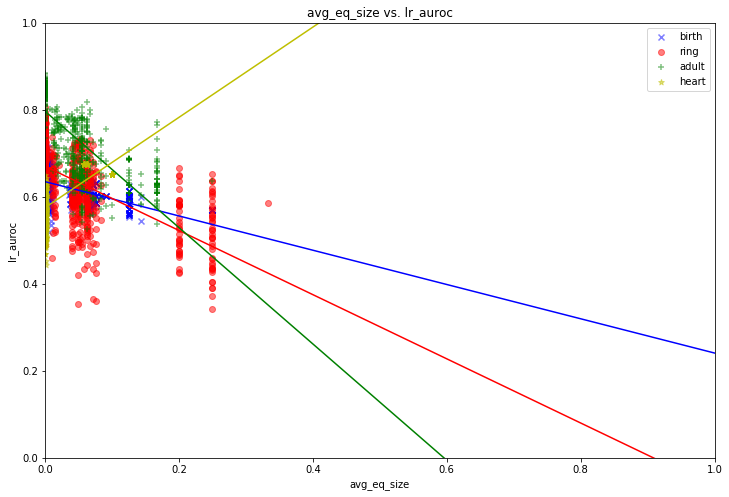

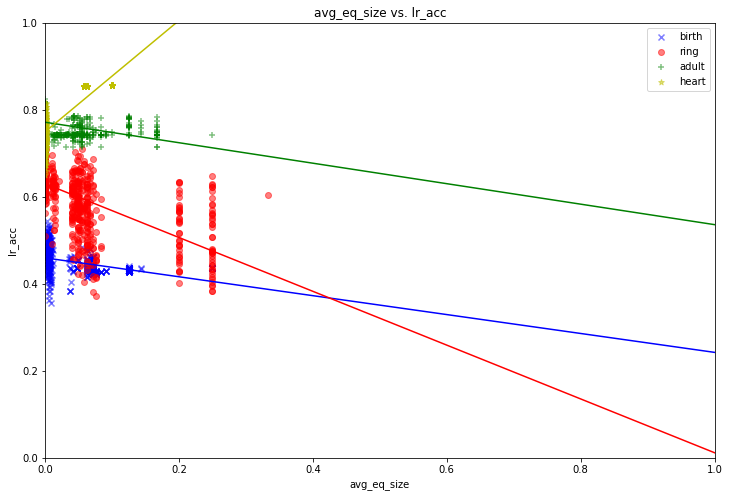

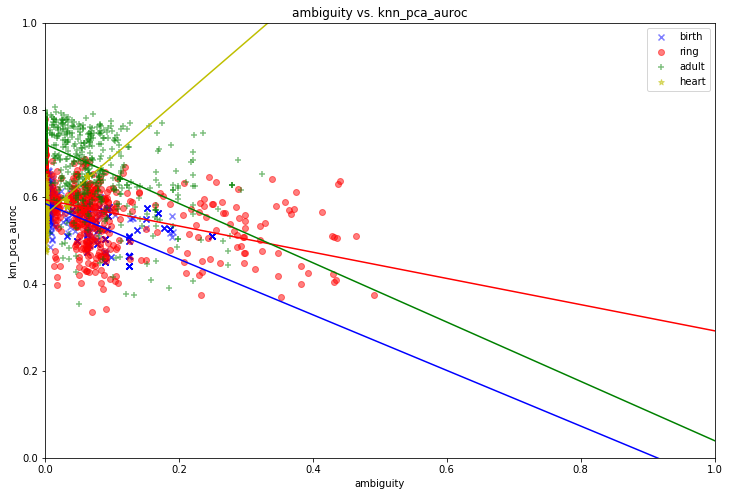

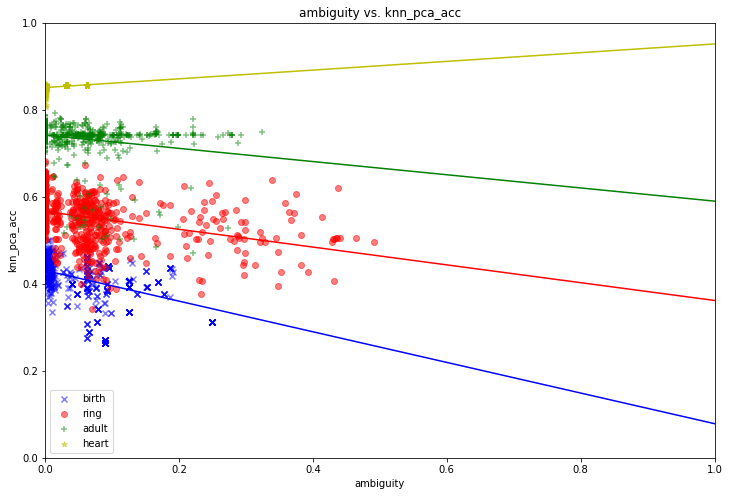

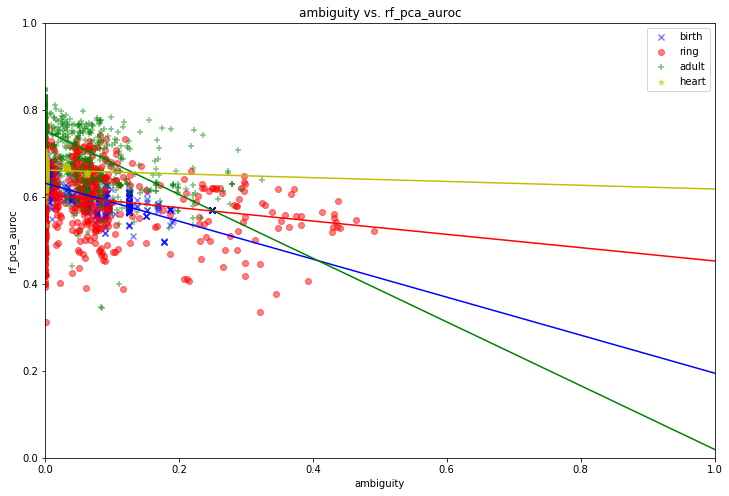

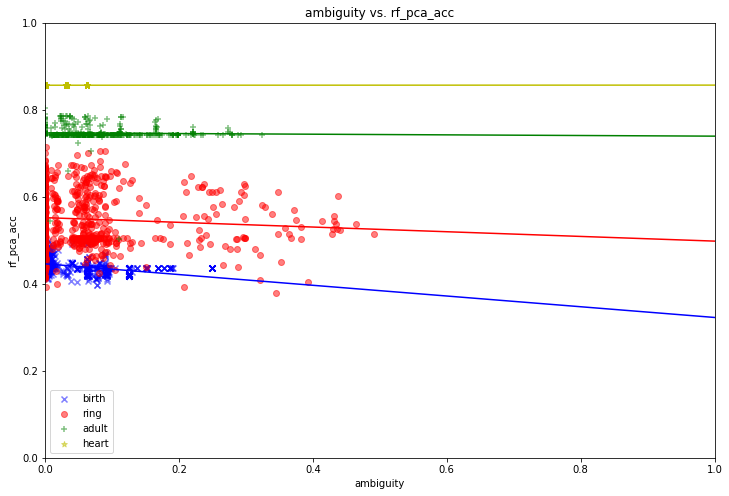

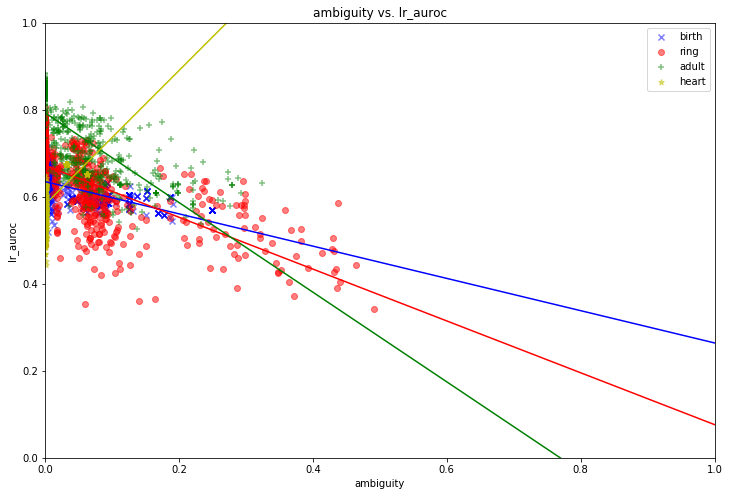

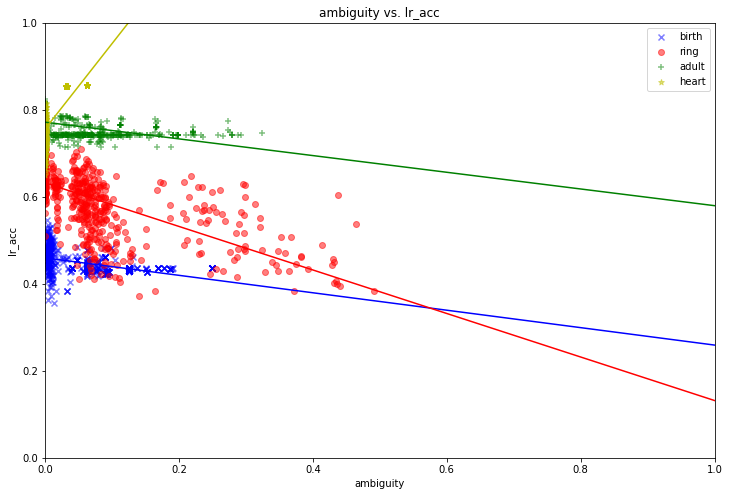

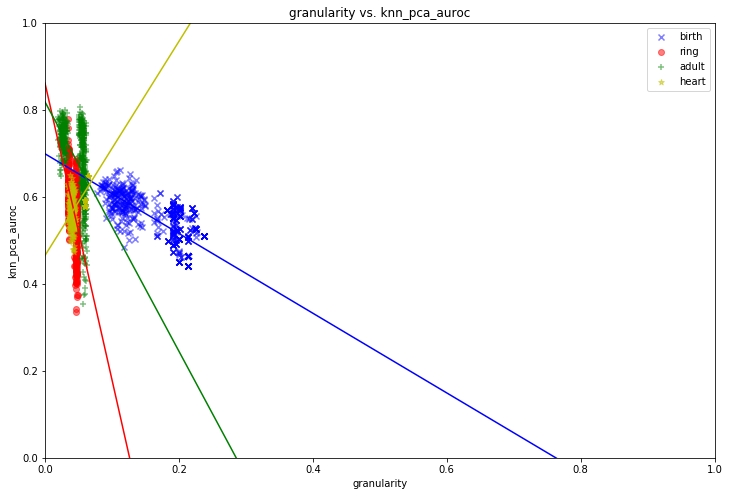

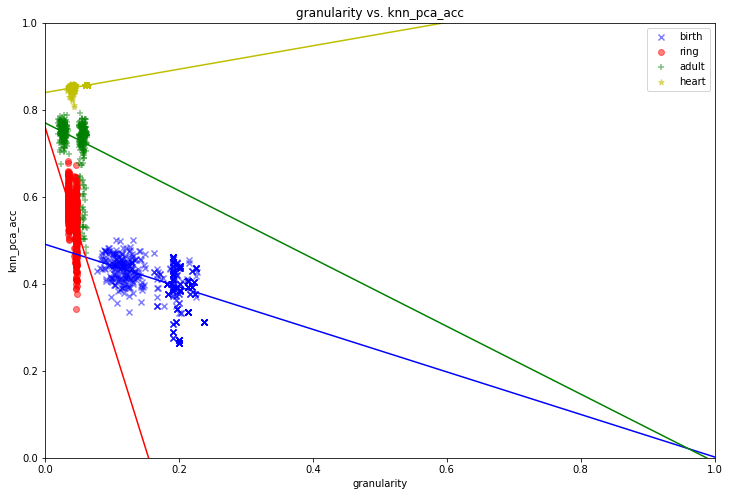

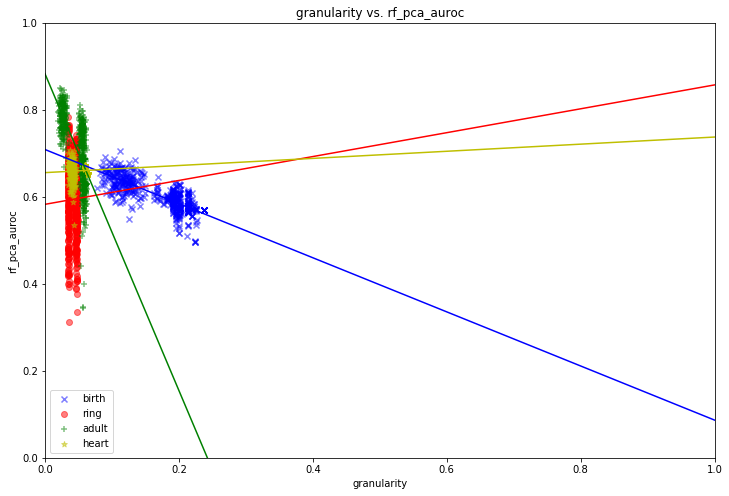

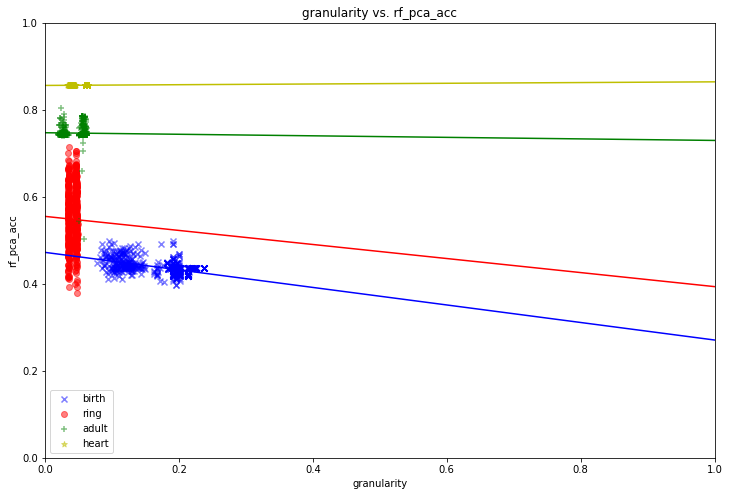

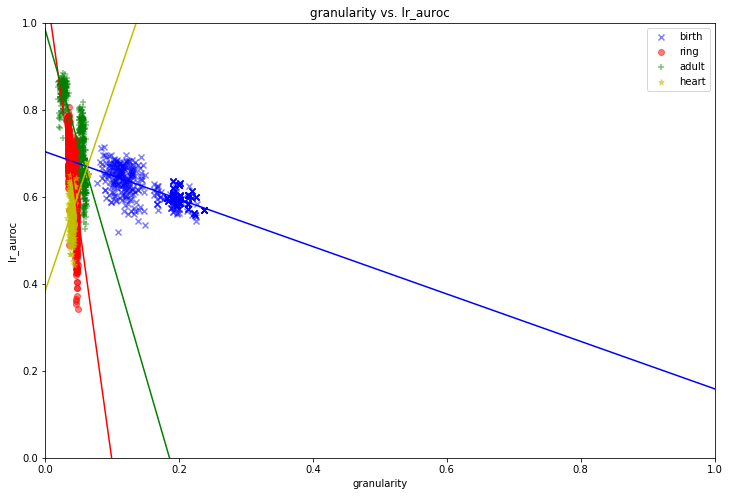

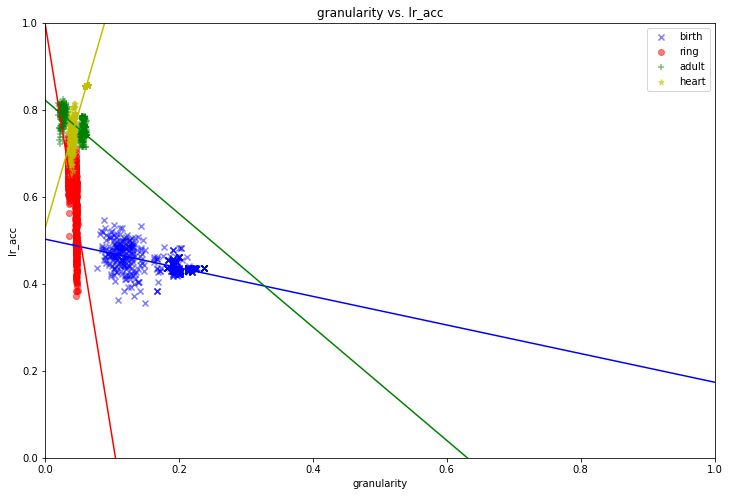

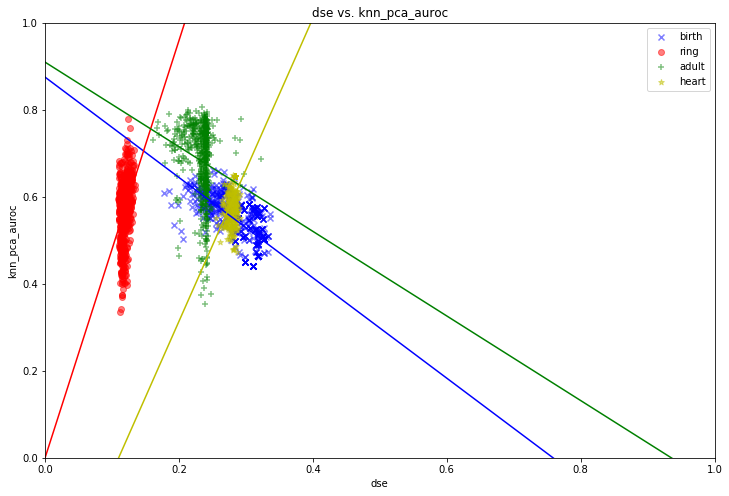

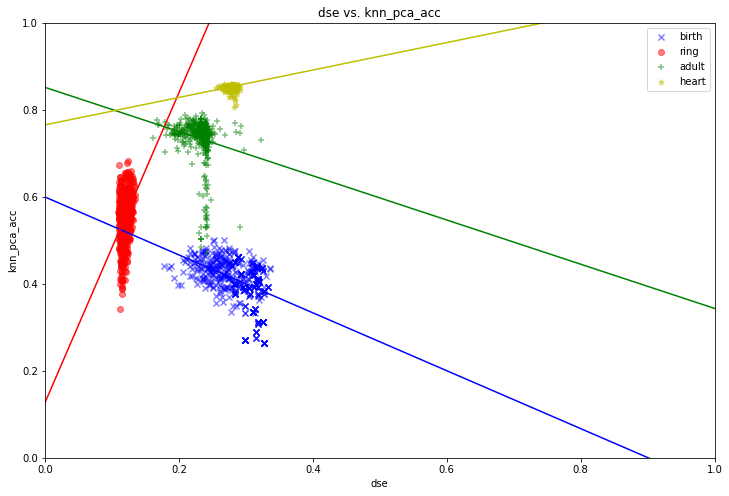

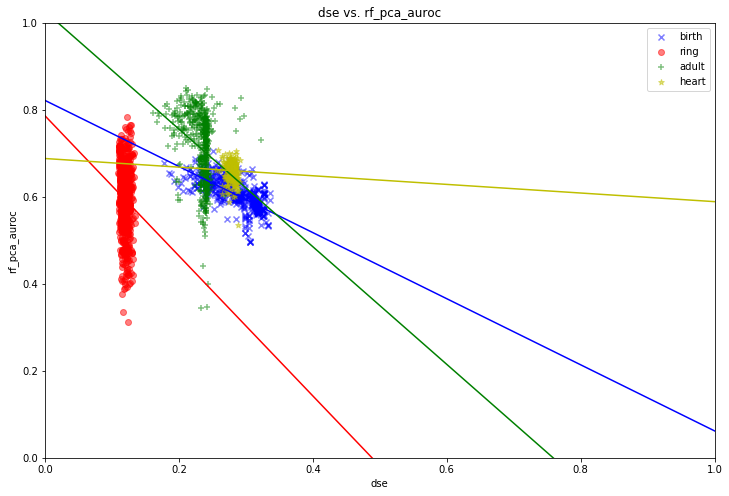

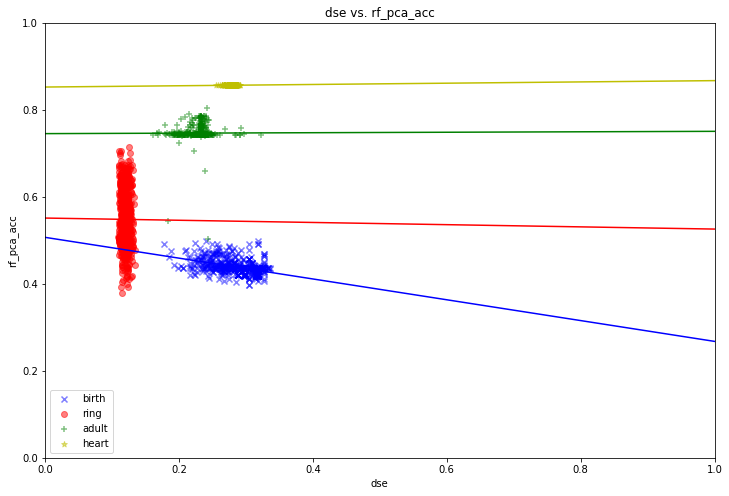

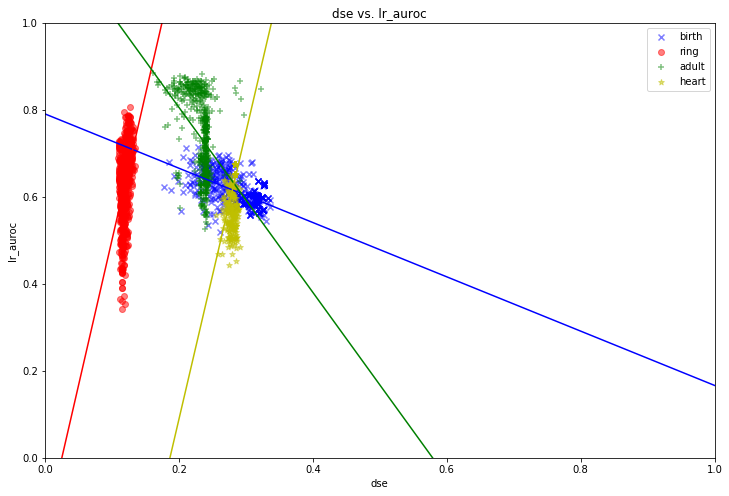

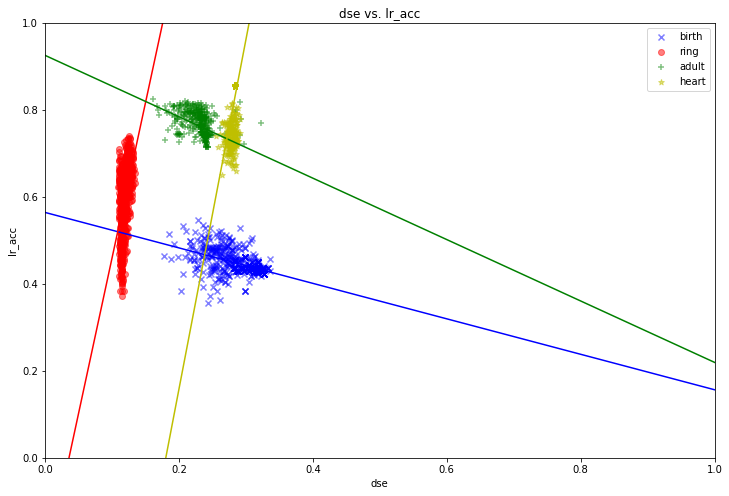

In [5]:
for m in metrics.columns[3:]:
    for target in accs.columns[3:]:
        plot_metric(m, target)

# 2) Mega Metric Scatters
Je plot ici des scatter plots des 4 datasets et de leur mega metric obtenus avec les mesures d'utilites differentes.

In [6]:
def mega_scatter(target):
    plt.figure(figsize=(12,8))
    for dataset, acc_set, col, mark, label in plot_info:
        X_test = pd.read_csv(f"{label}_randoms/metrics_testset.csv")
        X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)

        y_test = pd.read_csv(f"{label}_randoms/accuracies_testset.csv")
        y_test = y_test[target]

        model = pickle.load(open(f"autosklearn_models/automl_{label}_randoms_{target}.pkl", "rb"))
        pred_y = model.predict(X_test)
        plt.scatter(pred_y, y_test, c=col, marker=mark, alpha=0.5, label=label)
        
        lin_reg = LinearRegression().fit(pred_y.reshape(-1,1), y_test)
        x=[[0],[1]]
        plt.plot(x, lin_reg.predict(x), c=col, alpha=0.5)

        plt.title(f"Mega Metric for {target} as utility measure")
        plt.xlabel("Predicted Score")
        plt.ylabel("Actual Score")
        plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()
    

/usr/local/lib/python3.7/site-packages/pyparsing.py:3174: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


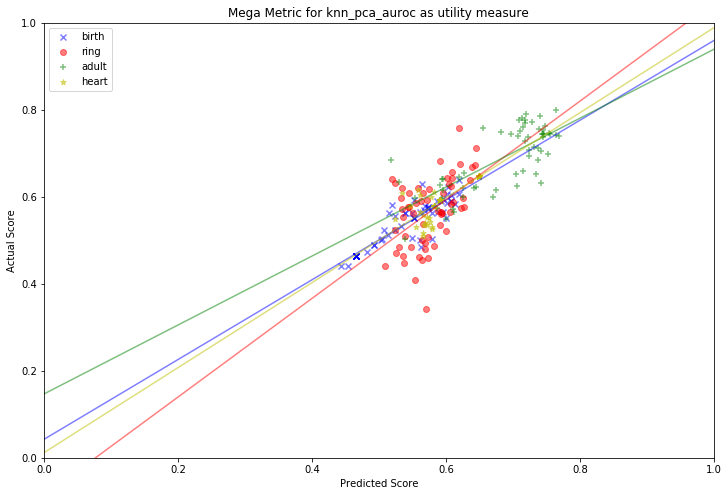

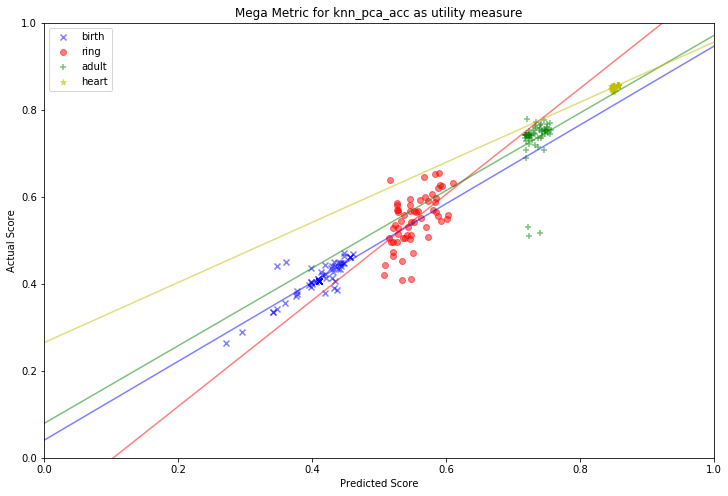

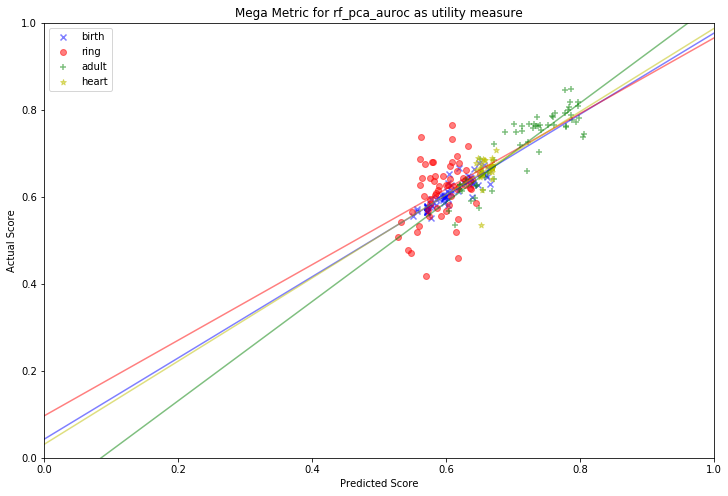

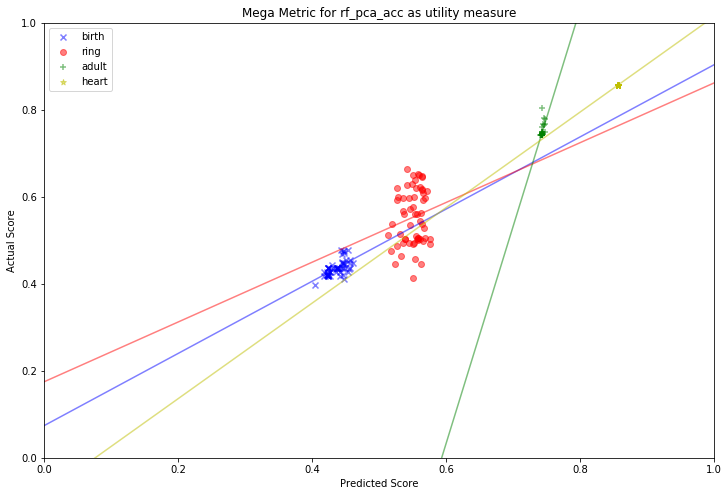

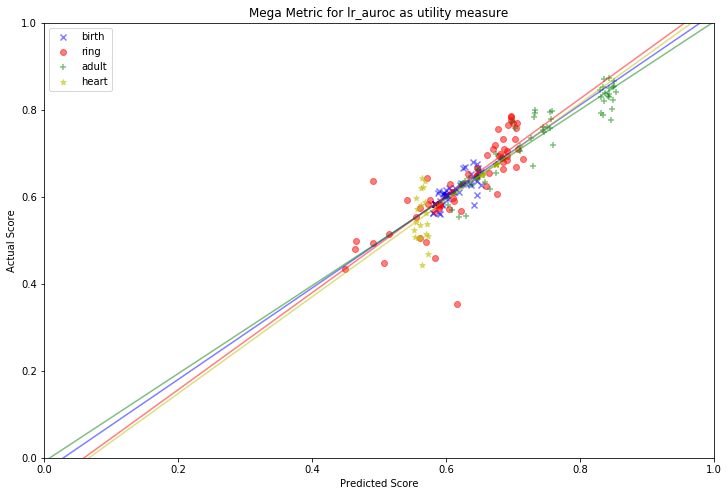

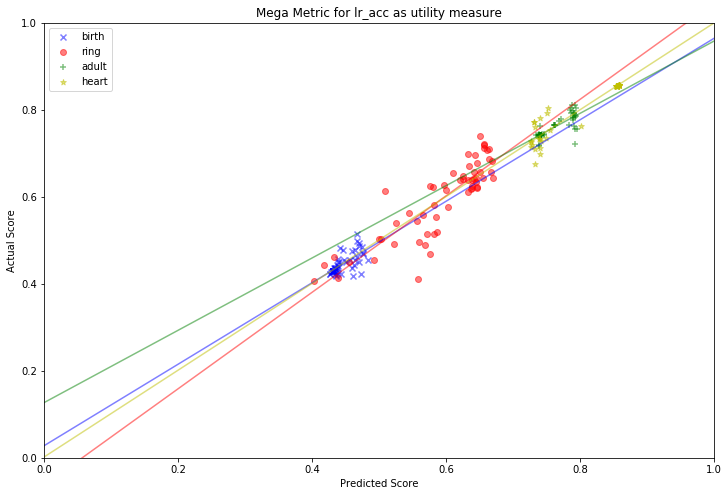

In [7]:
for target in accs.columns[3:]:
    mega_scatter(target)

# 3) Use a Dataset's Mega Metrics on others?
Here, we try to predict a dataset's utility using the mega metric from another dataset. You'll see that it doesn't work. At all...

In [8]:
def cross_test(orig_label, target):
    plt.figure(figsize=(12,8))
    model = pickle.load(open(f"autosklearn_models/automl_{orig_label}_randoms_{target}.pkl", "rb"))
    
    for dataset, acc_set, col, mark, label in plot_info:
        if label != orig_label:

            X_test = pd.read_csv(f"{label}_randoms/metrics_testset.csv")
            X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)

            y_test = pd.read_csv(f"{label}_randoms/accuracies_testset.csv")
            y_test = y_test[target]


            pred_y = model.predict(X_test)
            plt.scatter(pred_y, y_test, c=col, marker=mark, alpha=0.5, label=label)

            lin_reg = LinearRegression().fit(pred_y.reshape(-1,1), y_test)
            x=[[0],[1]]
            plt.plot(x, lin_reg.predict(x), c=col, alpha=0.5)

            plt.title(f"{orig_label} Mega Metric for {target} on other datasets")
            plt.xlabel("Predicted Score")
            plt.ylabel("Actual Score")
        plt.ylim(0,1)
        plt.xlim(0,1)
        plt.legend()
    plt.show()

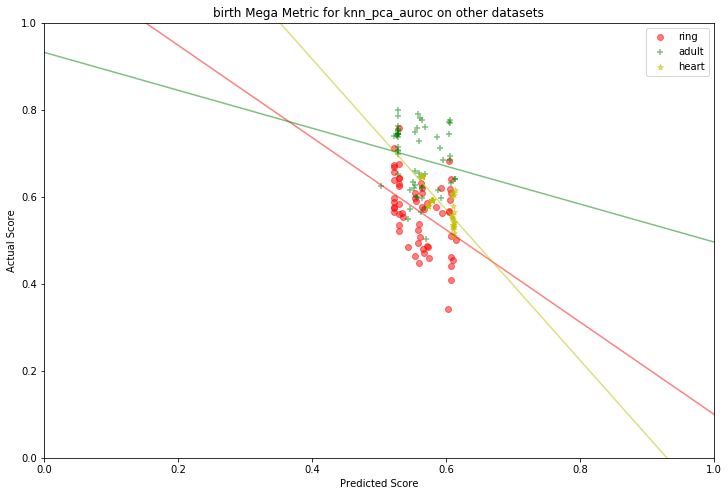

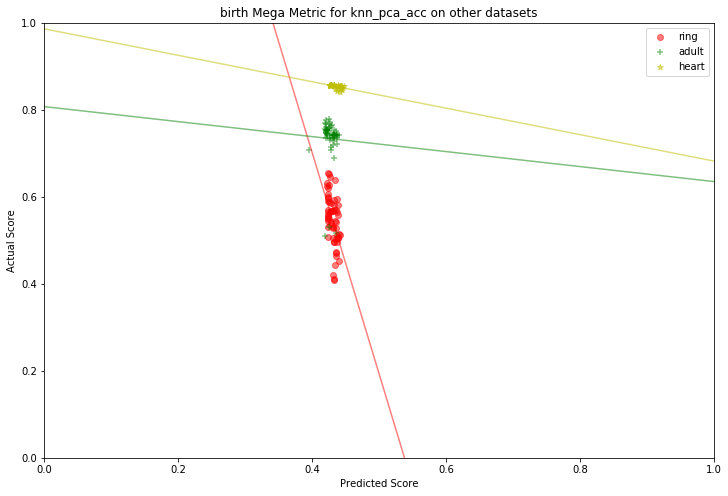

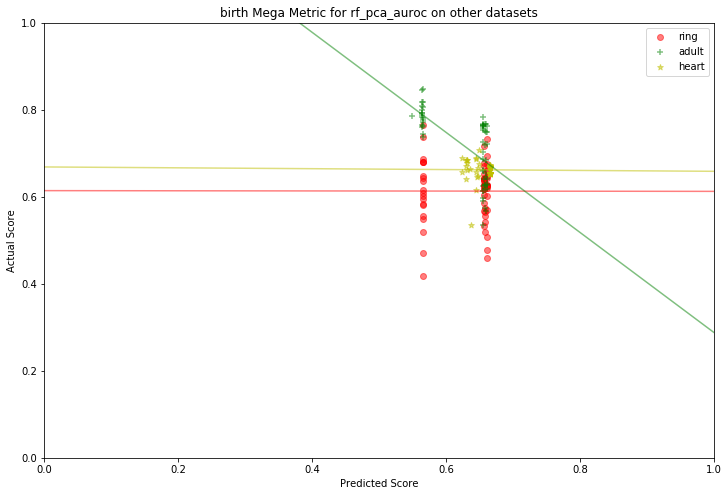

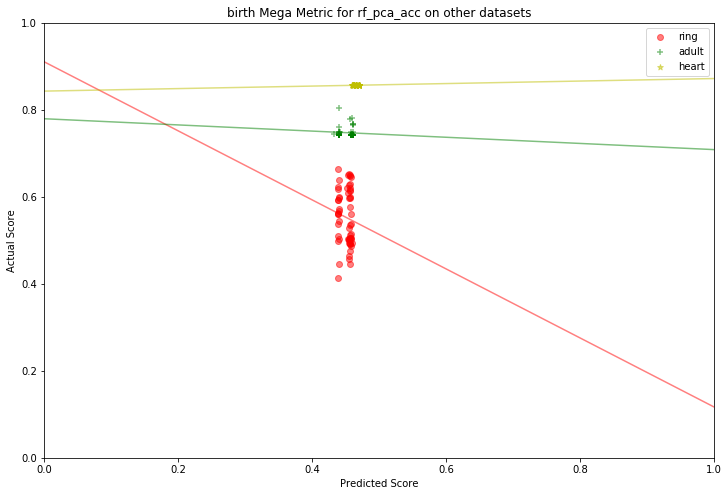

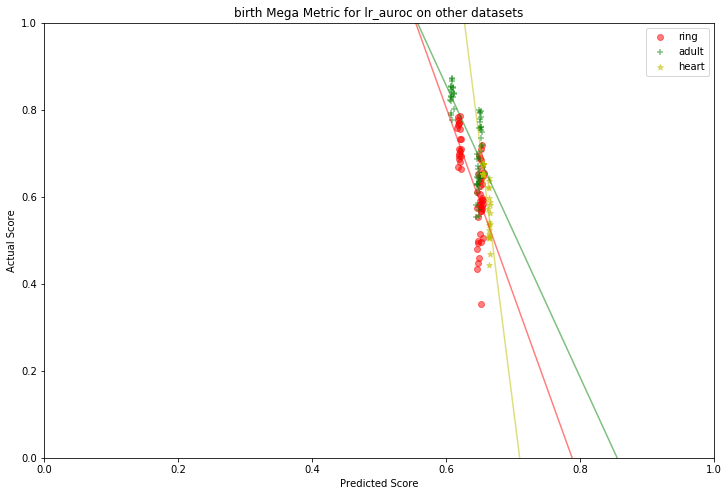

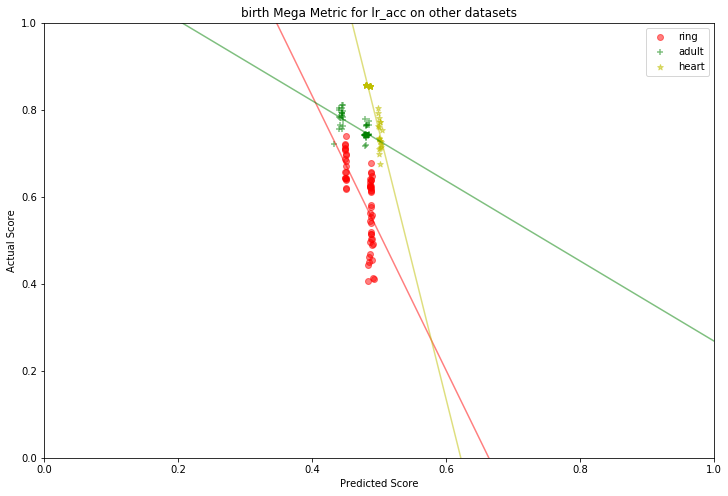

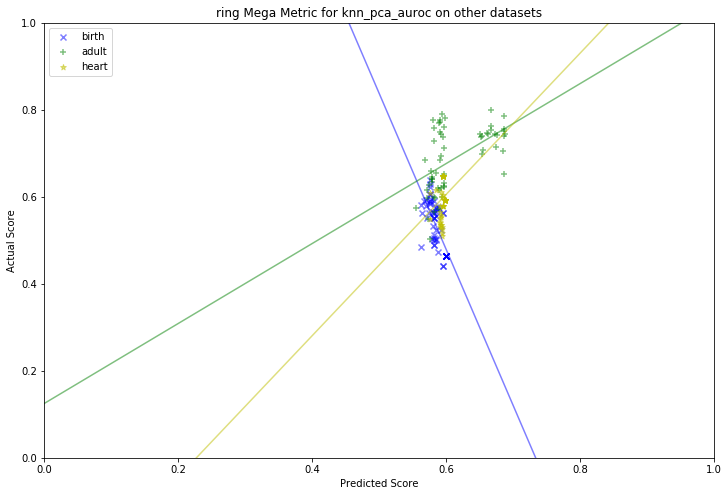

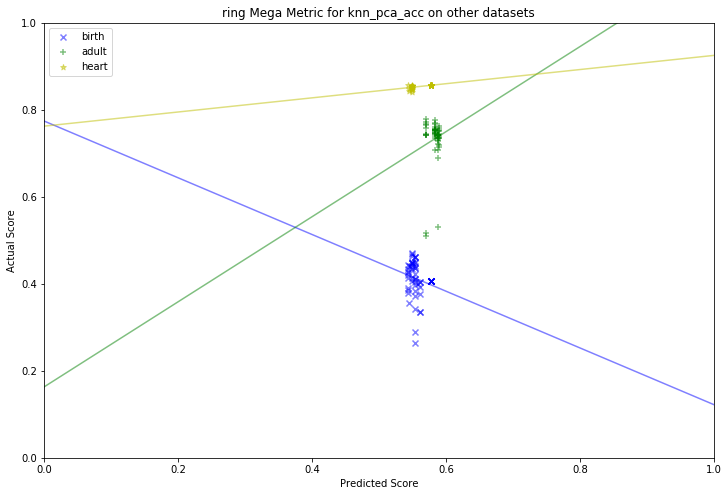

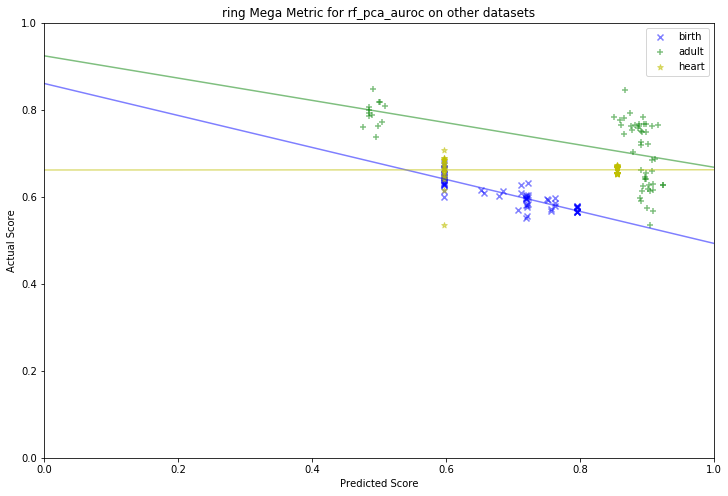

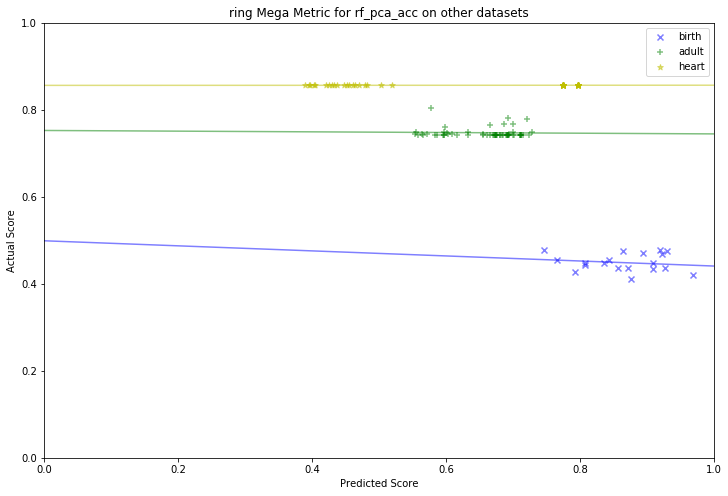

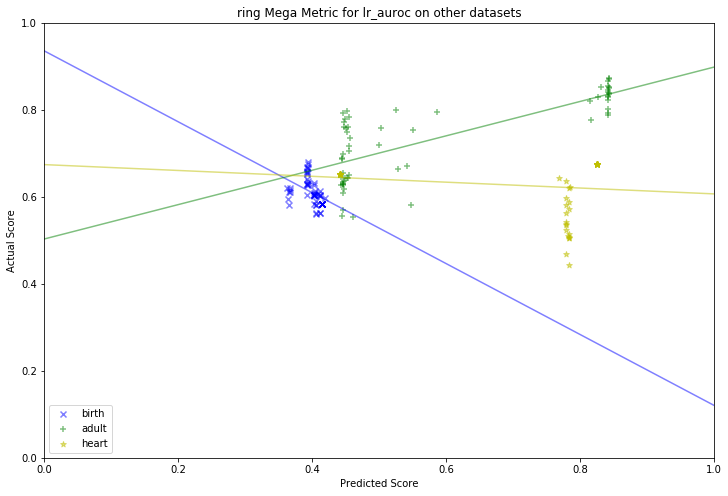

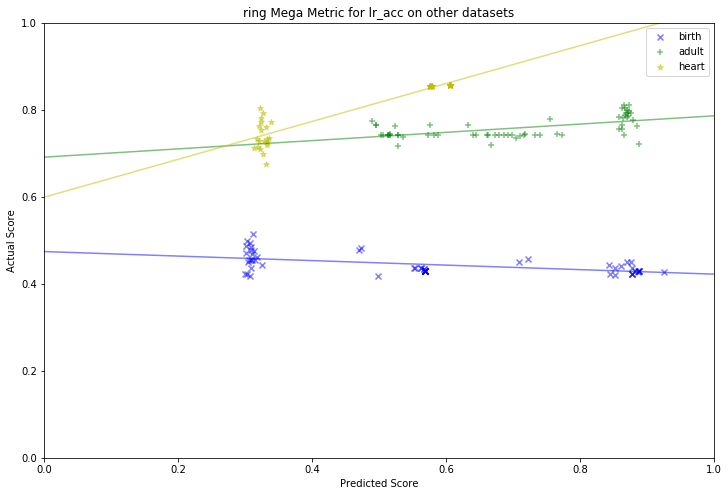

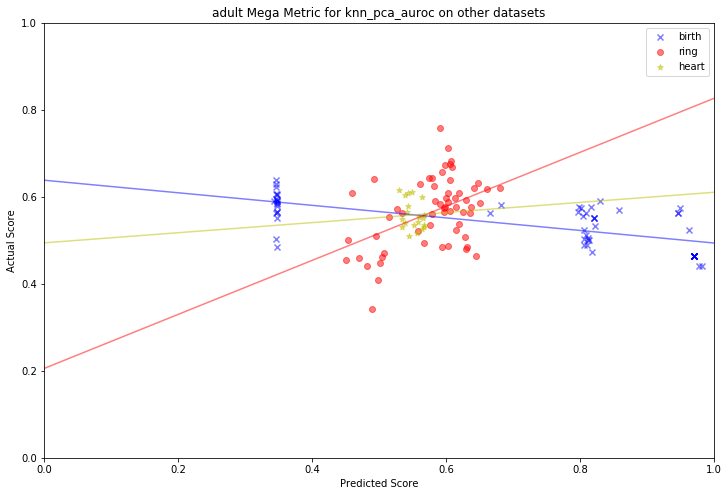

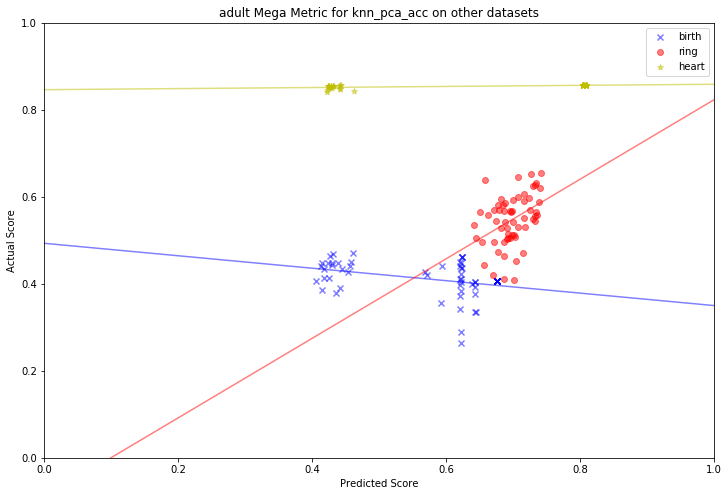

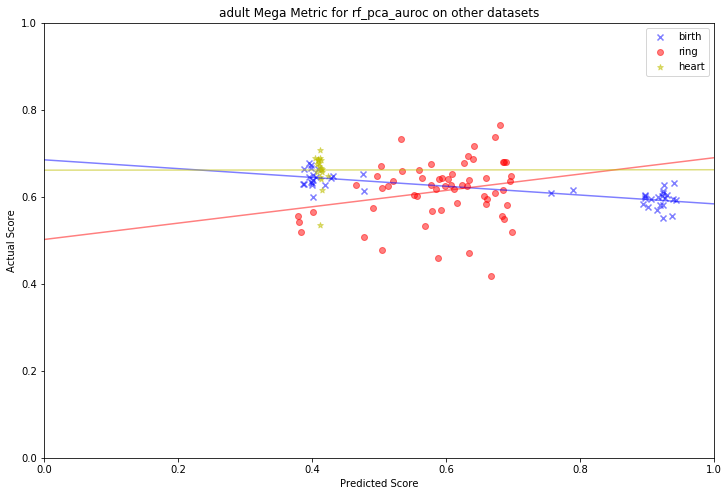

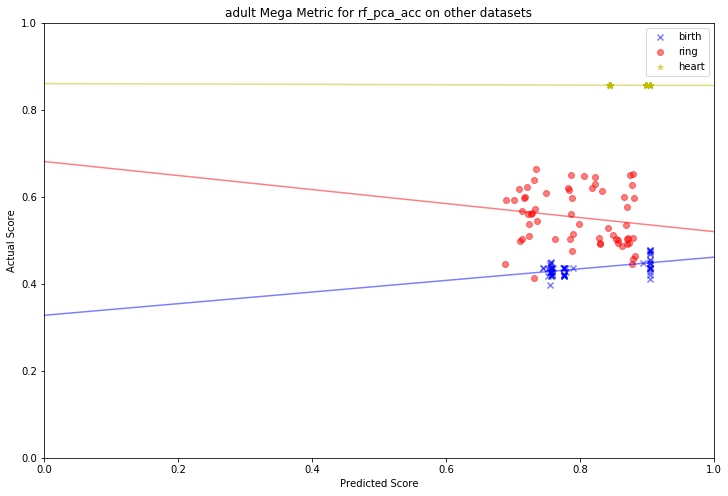

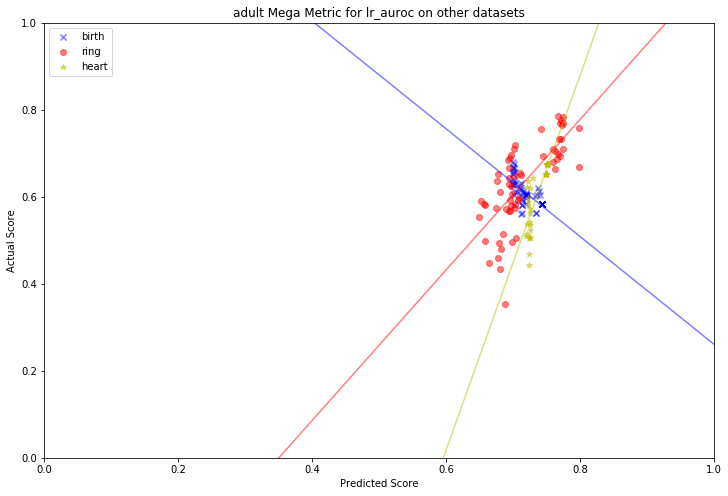

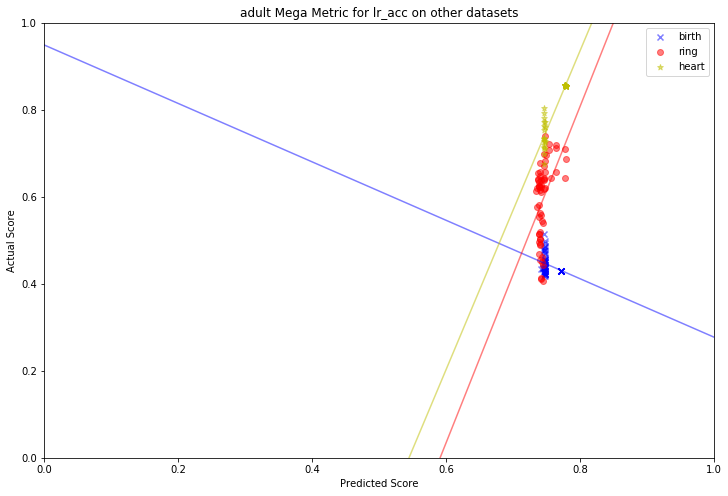

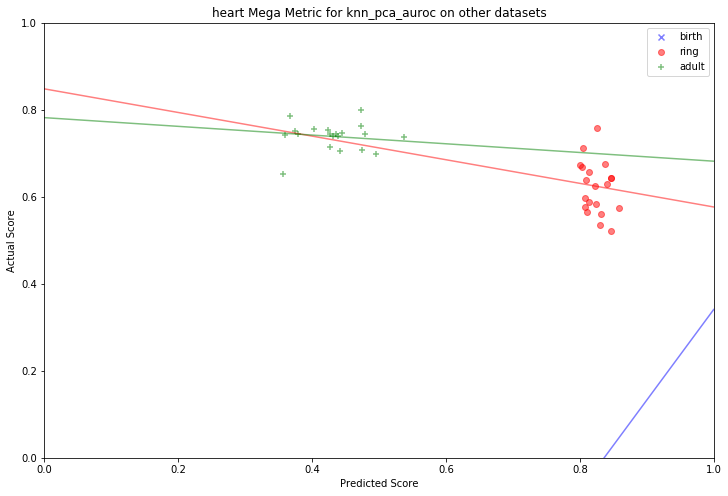

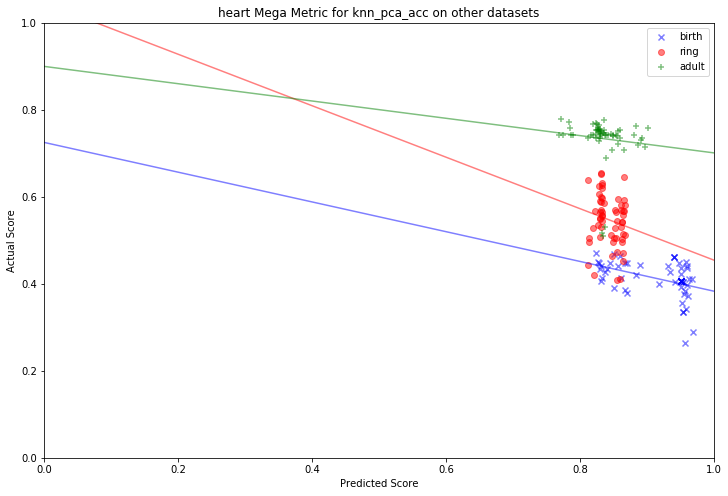

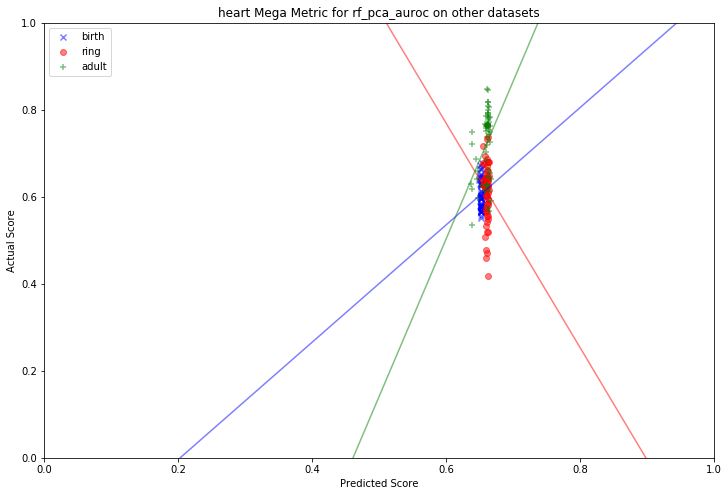

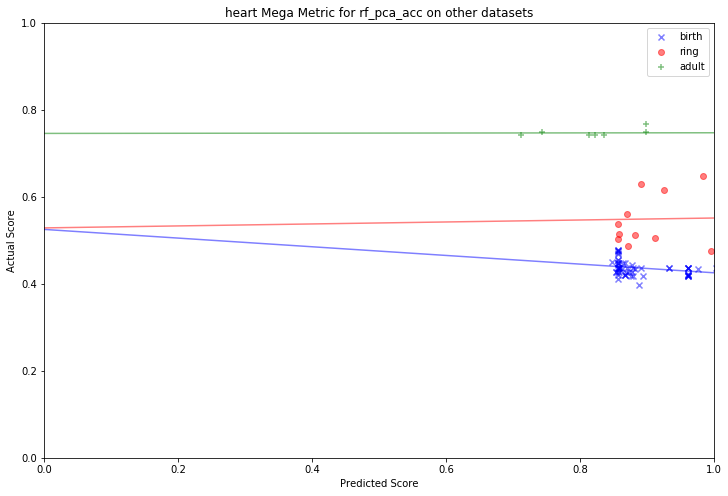

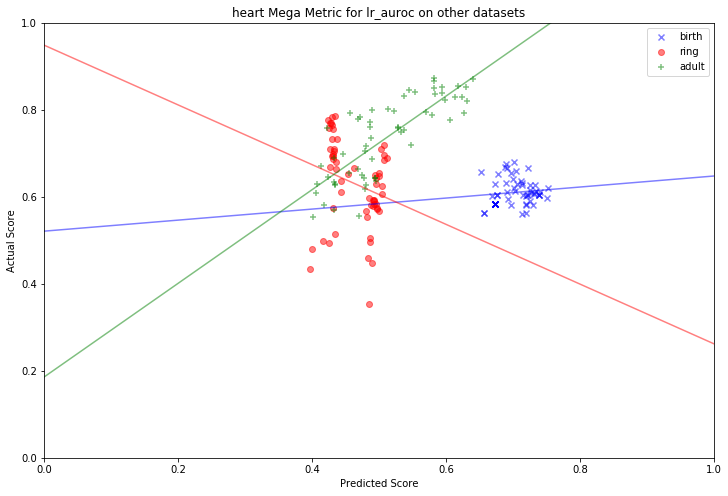

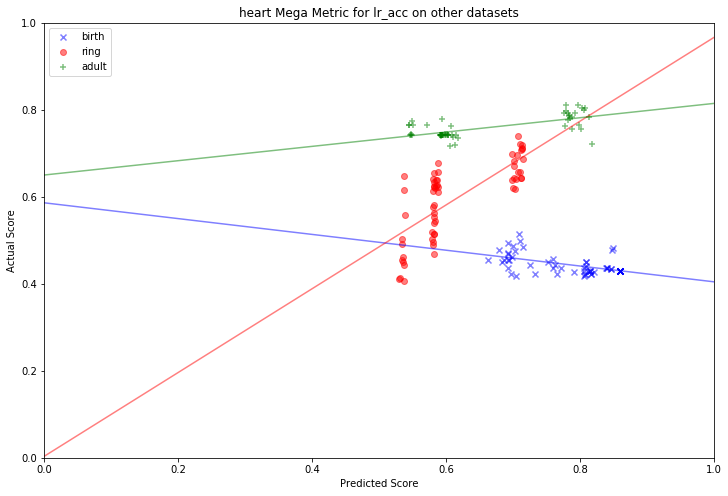

In [9]:
for _, _, _, _, label in plot_info:
    for target in accs.columns[3:]:
        cross_test(label, target)

# 4) Using one utility mega metric, can I predict another mega metric (same dataset). ie., does one target variable suffice?

In [10]:
util_measures = ["lr_acc", "lr_auroc", "rf_pca_acc", "rf_pca_auroc", "knn_pca_acc", "knn_pca_auroc"]


def cross_target(label, target):
    model = pickle.load(open(f"autosklearn_models/automl_{label}_randoms_{target}.pkl", "rb"))

    X_test = pd.read_csv(f"{label}_randoms/metrics_testset.csv")
    X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)

    other_targets = pd.read_csv(f"{label}_randoms/accuracies_testset.csv")[util_measures]
    other_targets = other_targets.drop(target, axis=1)

    plt.figure(figsize=(12,8))
    for t in other_targets.columns:
        y_test = other_targets[t]
        pred_y = model.predict(X_test)
        plt.scatter(pred_y, y_test, alpha=0.5)
        lin_reg = LinearRegression().fit(pred_y.reshape(-1,1), y_test)
        x=[[0],[1]]
        plt.plot(x, lin_reg.predict(x),label=t,alpha=0.5)
    plt.title(f"{label} Mega Metric for {target} as a predictor for other utility measures")
    plt.xlabel(f"Predicted utility using {target}")
    plt.ylabel(f"Predicted utility using other utility measures")
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

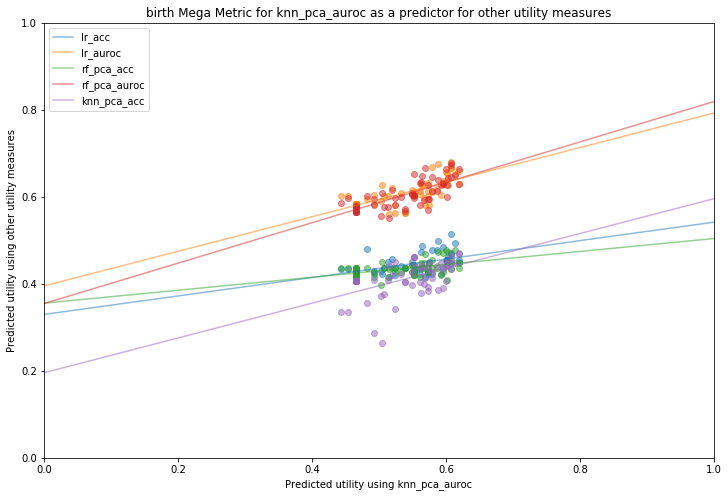

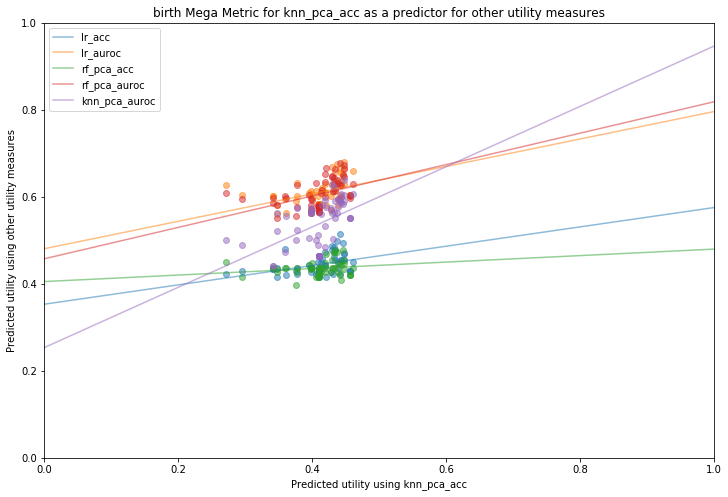

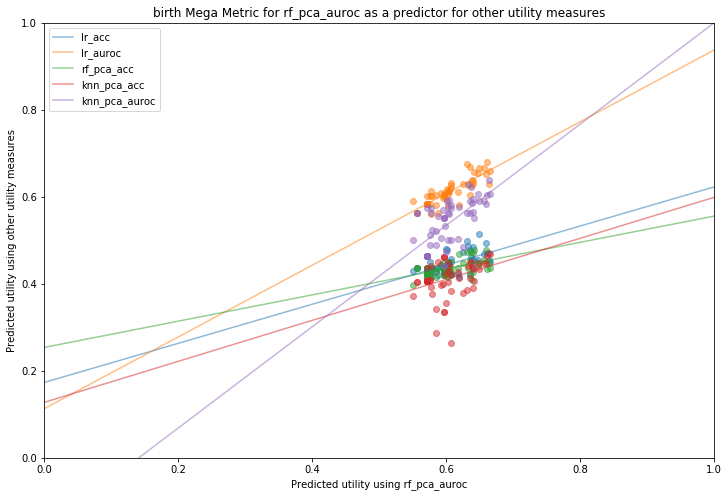

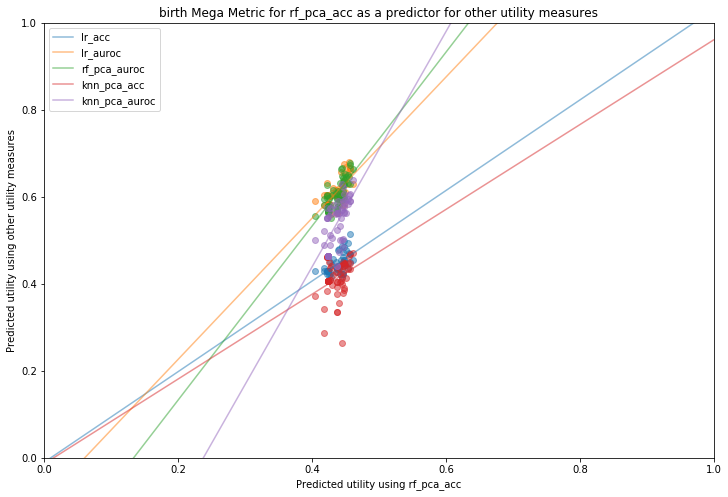

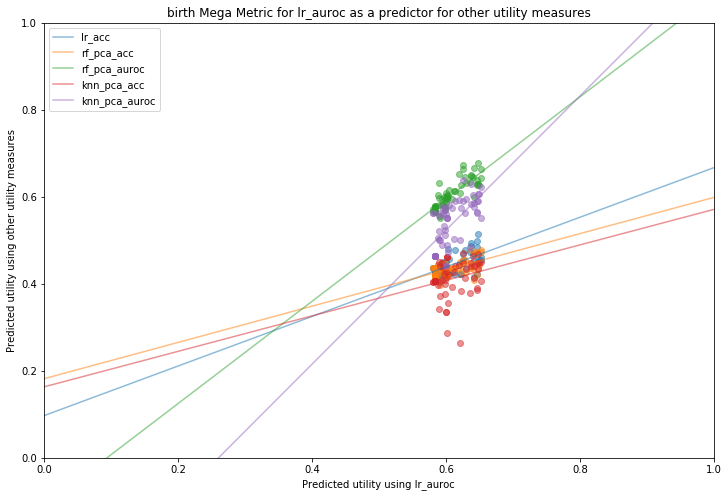

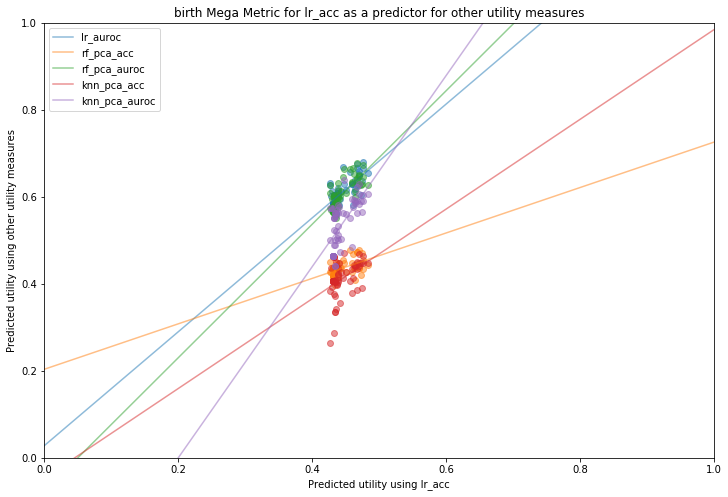

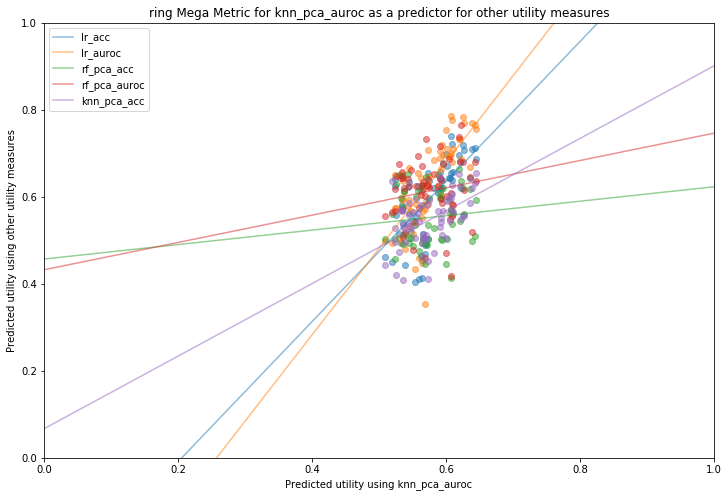

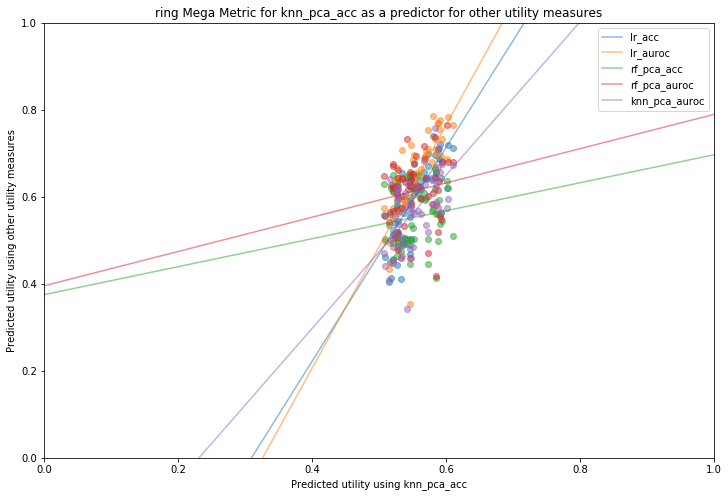

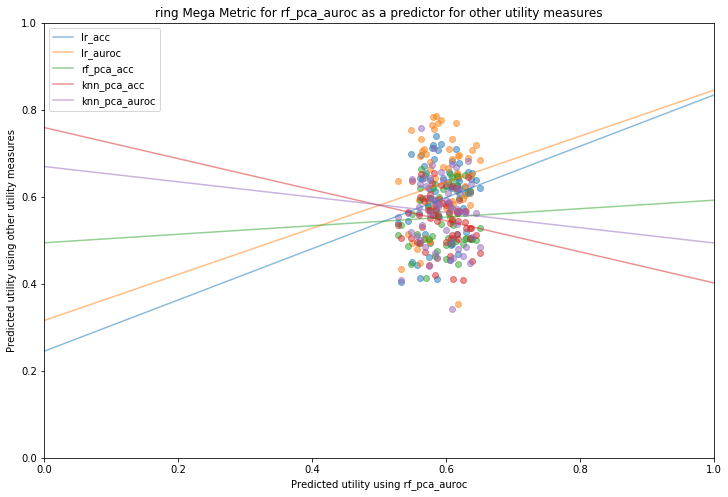

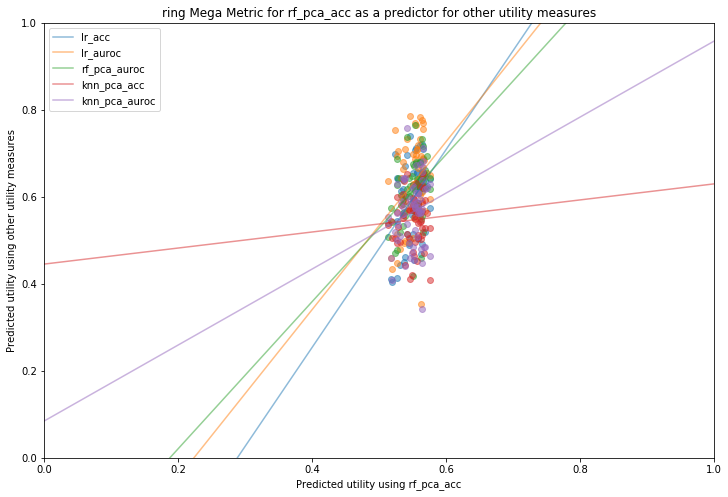

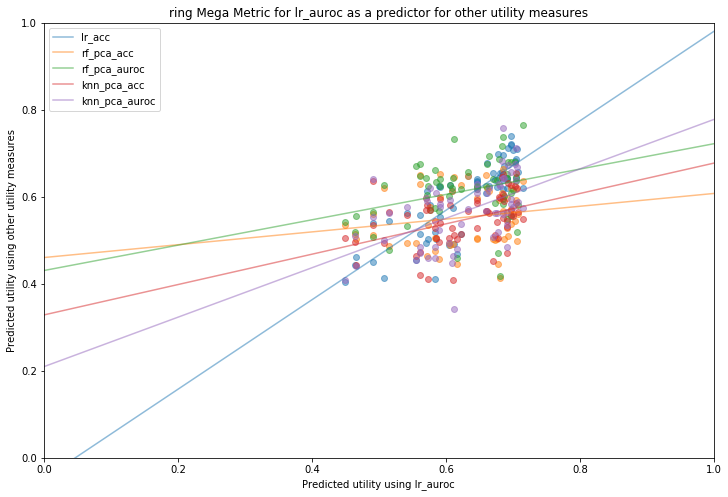

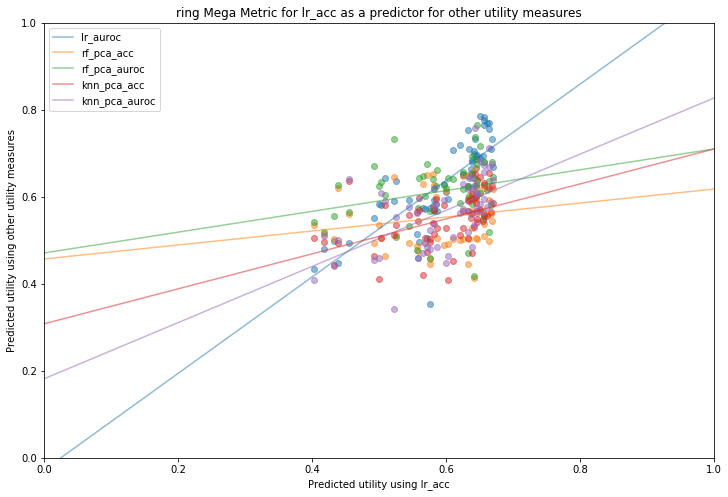

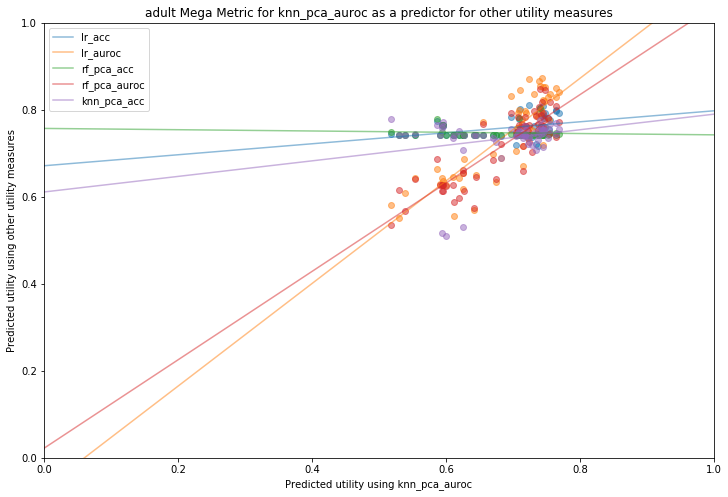

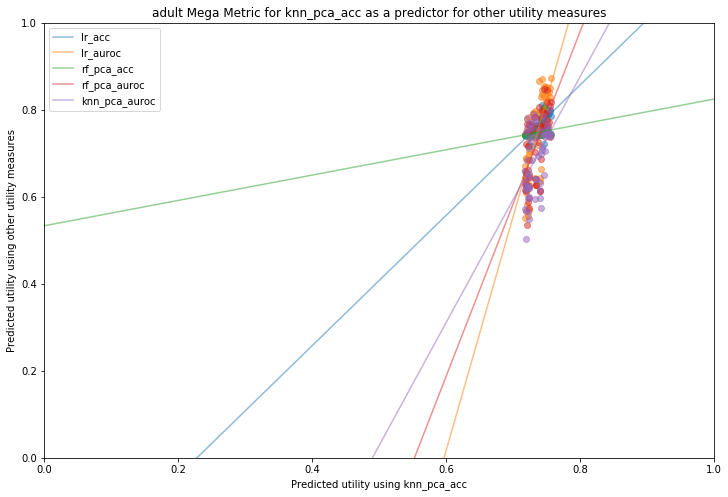

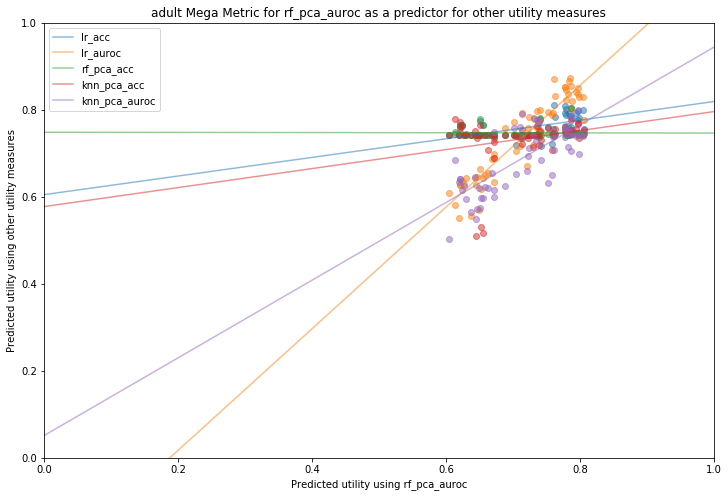

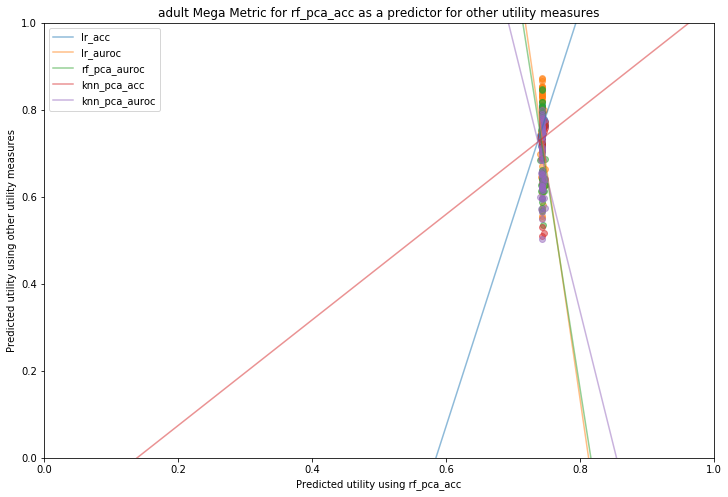

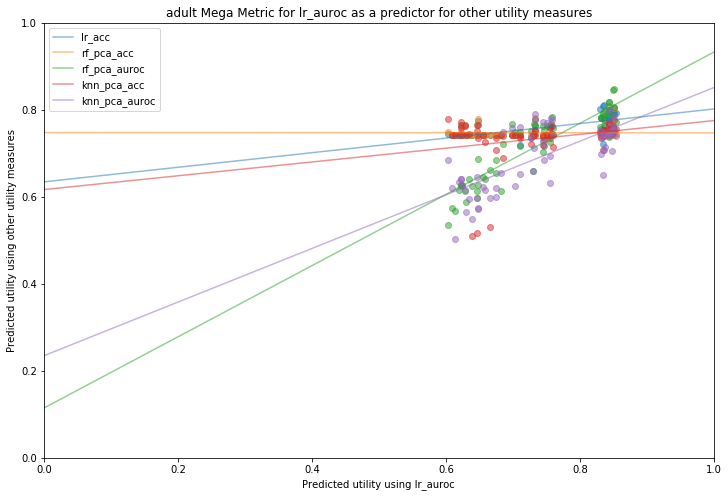

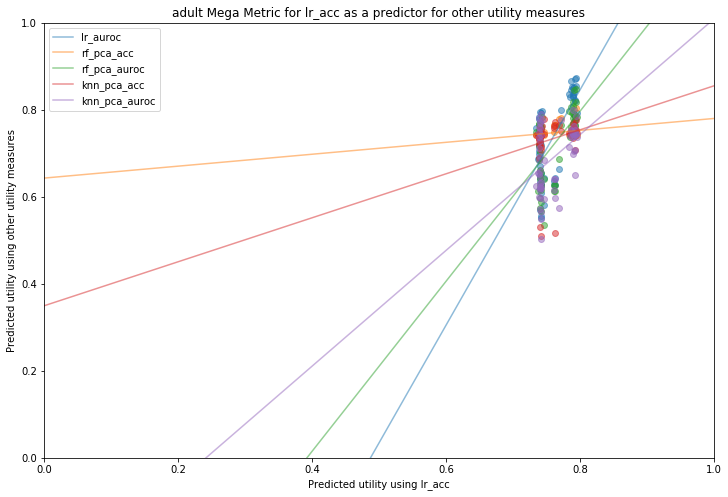

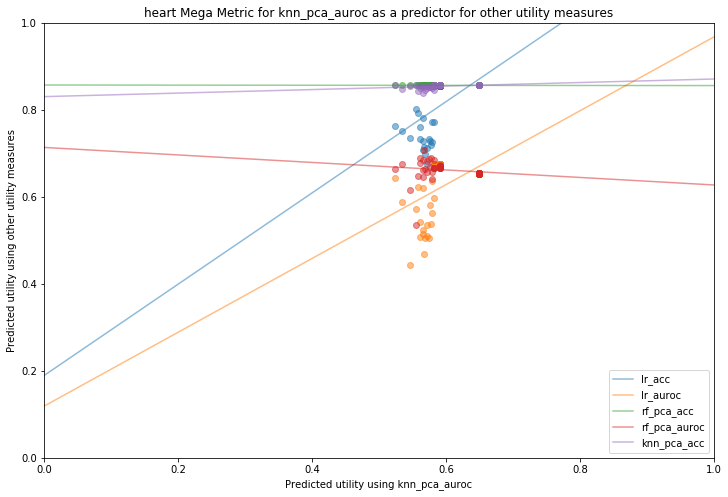

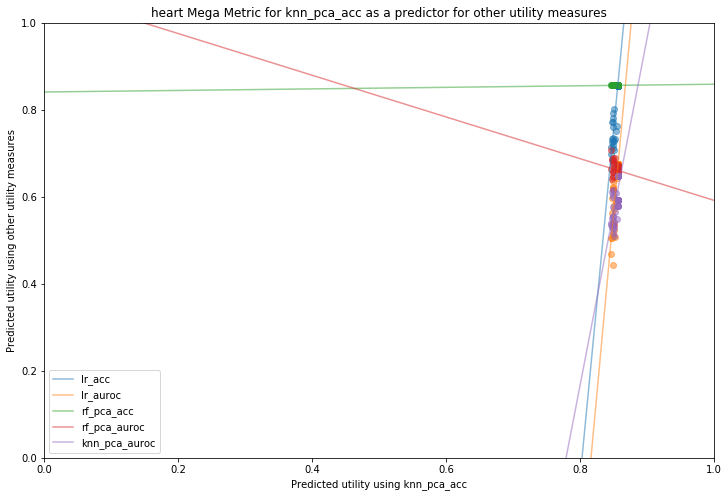

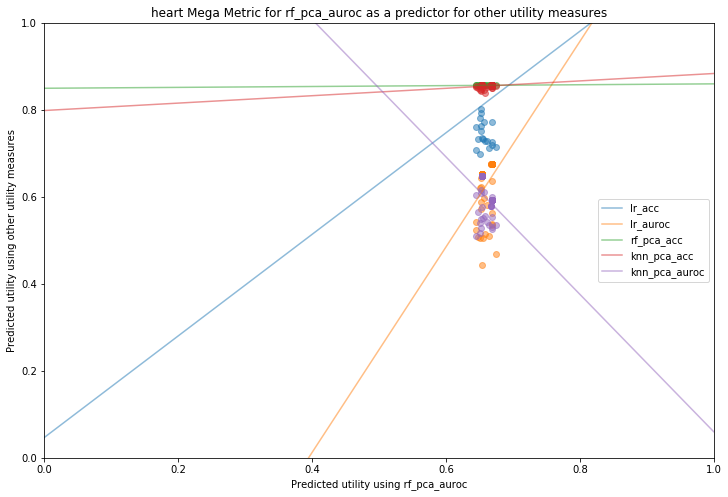

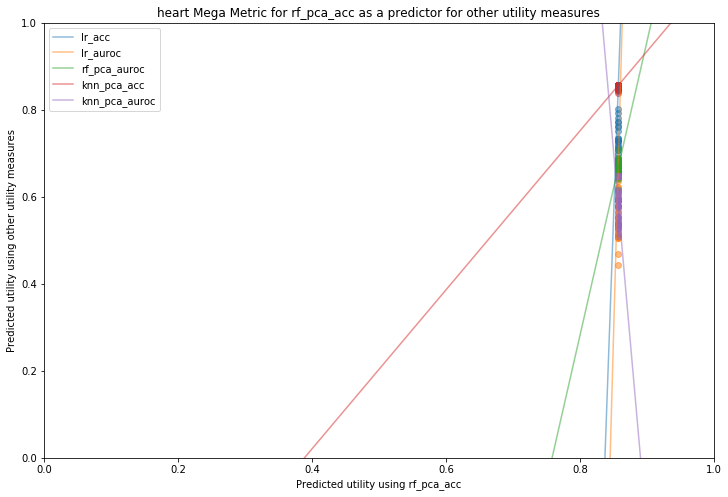

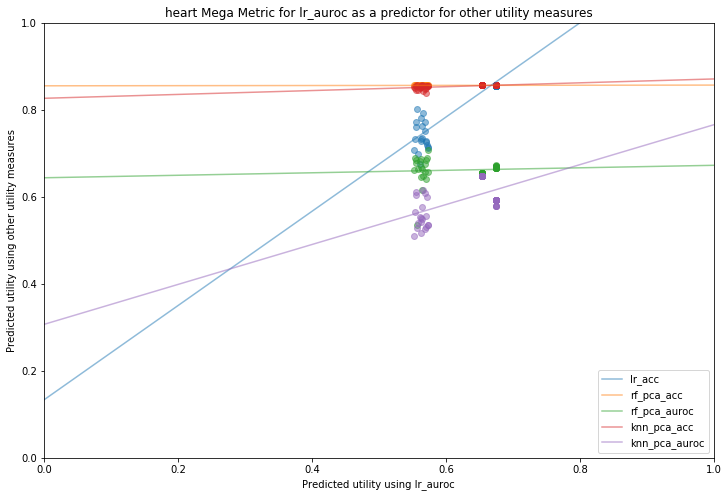

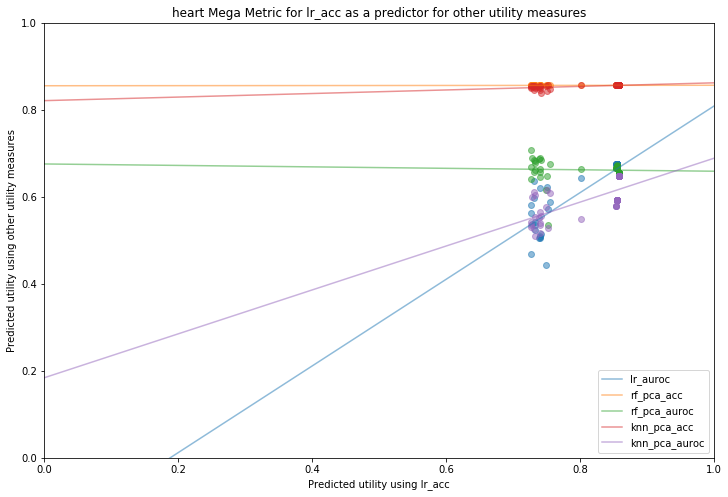

In [11]:
for dataset, acc_set, col, mark, label in plot_info:
    for target in accs.columns[3:]:
        cross_target(label, target)

# 5) Single plot of all mega metrics per dataset

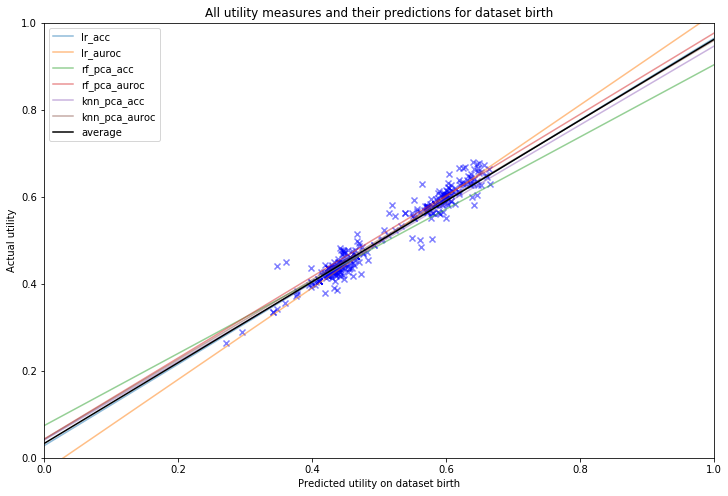

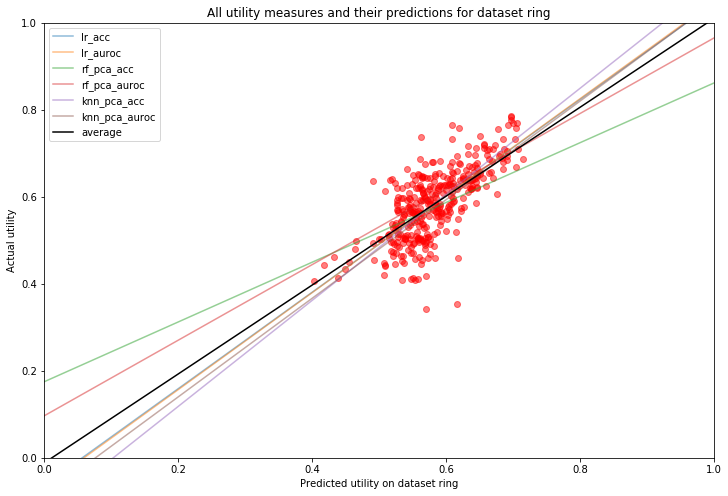

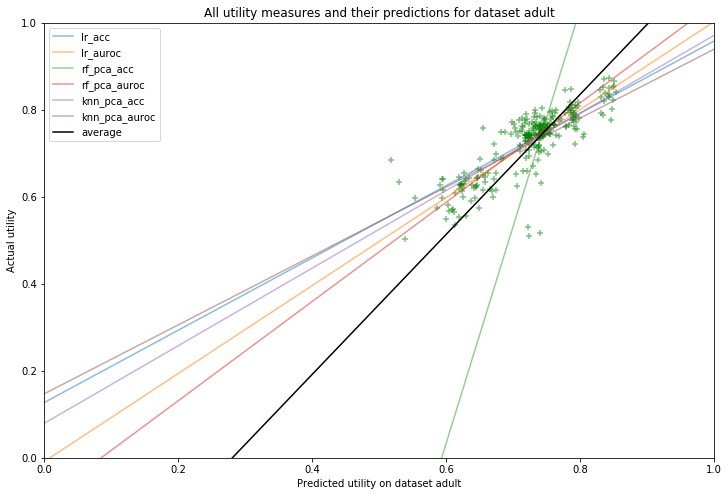

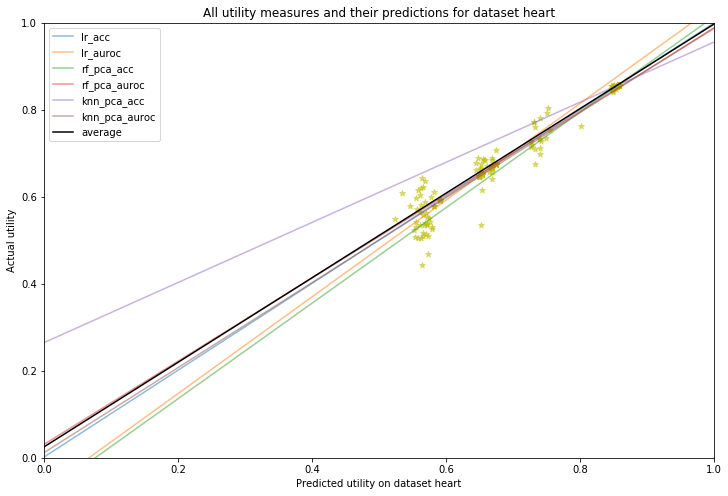

In [16]:
for dataset, acc_set, col, mark, label in plot_info:
    
    X_test = pd.read_csv(f"{label}_randoms/metrics_testset.csv")
    X_test = X_test.drop(["lr_acc", "algo", "no", "auroc"], axis=1)
    
    plt.figure(figsize=(12,8))
    coefs, ints = [], []
    
    for target in util_measures:
        model = pickle.load(open(f"autosklearn_models/automl_{label}_randoms_{target}.pkl", "rb"))
        y_test = pd.read_csv(f"{label}_randoms/accuracies_testset.csv")[target]
        pred_y = model.predict(X_test)
        plt.scatter(pred_y, y_test, marker=mark, c=col, alpha=0.5)
        lin_reg = LinearRegression().fit(pred_y.reshape(-1,1), y_test)
        coefs.append(lin_reg.coef_)
        ints.append(lin_reg.intercept_)
        x=[[0],[1]]
        plt.plot(x, lin_reg.predict(x),label=target,alpha=0.5)
        plt.title(f"All utility measures and their predictions for dataset {label}")
        
        
    c_avg = sum(coefs)/len(coefs)
    i_avg = sum(ints)/len(ints)
    x=[[0],[1]]
    plt.plot(x, [i_avg, i_avg+c_avg],c="black", label="average")
    
    plt.xlabel(f"Predicted utility on dataset {label}")
    plt.ylabel(f"Actual utility")
    plt.legend()
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()